Read transport!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def read_data(filename,loopfit,ohe_antisym_prec=20,ohe_sym_prec=20):
    '''
    filename should be of the format 'filename.txt'
    '''
    data=pd.read_csv(filename,sep='\t')
    data.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
    
    def shave():
        B=[float(i) for i in data.B[2:]]
        I=[float(i) for i in data.I_gate[2:]]
        Rxx=[float(i) for i in data.R_xx[2:]]
        Rxy=[float(i) for i in data.R_xy[2:]]
        Thetaxy=[float(i) for i in data.Theta_xy[2:]]
        Thetaxx=[float(i) for i in data.Theta_xx[2:]]
        Thetaxy=[np.cos(np.deg2rad(i)) for i in Thetaxy]
        Thetaxx=[np.cos(np.deg2rad(i)) for i in Thetaxx]
        Rxy=[-Rxy[i]*Thetaxy[i] for i in range(len(Rxy))] #muliplying by the phase
        Rxx=[Rxx[i]*Thetaxx[i] for i in range(len(Rxx))] #muliplying by the phase
        npl=np.array(B)
        #getting rid of zeroes
        #[npz]=np.where(npl==0)
        #getting rid of repeating points at the opposite ends of the sweep
        [nplmax]=np.where(npl==np.max(npl))
        if len(nplmax)!=0:
            indmid1=len(nplmax)//2 #the middle one, because why not
            indrep=np.delete(nplmax,indmid1)#list of indices where we're stuck at repeating 7
        else:
            indrep=[0]
        [nplmin]=np.where(npl==np.min(npl))
        if len(nplmin)!=0:
            indmid2=len(nplmin)//2 #the middle one, because why not
            indrepm=np.delete(nplmin,indmid2)#list of indices where we're stuck at repeating 7
        else:
            indrepm=[0]
        #let's make a superlist of all the indices we want to rid lB of
        indtodel=indrep#np.append(npz,indrep)
        indtodel=np.append(indtodel,indrepm)
        proc_B=np.delete(B,indtodel)
        proc_I=np.delete(I,indtodel)
        proc_Rxx=np.delete(Rxx,indtodel)
        proc_Rxy=np.delete(Rxy,indtodel)
        return proc_B,proc_Rxx,proc_Rxy,proc_I
    
    proc_B,proc_Rxx,proc_Rxy,proc_I=shave()
    
    def plot_B(x):
        fig, ax = plt.subplots()
        xaxis=range(len(x))
        ax.plot(xaxis,x)
        plt.yticks([])
        plt.show()
    def plot_res(x):
        fig, ax = plt.subplots()
        xaxis=proc_B
        ax.plot(xaxis,x)
        plt.yticks()
        plt.show()
        
    #print((proc_Rxx[0]+proc_Rxx[-1])/2)   
    #plot_B(proc_B)
    #plot_res(proc_Rxx)
    #plot_res(proc_I)
    
    
    def antisymmetrize(mat,proc_B=proc_B):
        [hi_point]=np.where(proc_B==np.max(proc_B))[0]
        [lo_point]=np.where(proc_B==np.min(proc_B))[0]
        [mid_point]=np.where(proc_B==0)
        mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)<3:
            ensure_init_0=np.array([0])
            proc_B_t=np.append(ensure_init_0,proc_B)
            proc_B=proc_B_t
            [hi_point]=np.where(proc_B==np.max(proc_B))[0]
            [lo_point]=np.where(proc_B==np.min(proc_B))[0]
            [mid_point]=np.where(proc_B==0)
            mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)==3: #only one 0 value in the middle: affects he down sweep
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            smol_hi_zero=mid[2]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[smol_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[smol_mid_zero:lo_point]
        if len(mid)==4: #only the down sweep is affected
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        if len(mid)>4:
            raise ValueError('mid is bigger than 4...')
        ##valid if we start w positive first!
        ub1=proc_B[lo_point:smol_hi_zero]
        ub2=proc_B[big_lo_zero:hi_point]
        u1=mat[lo_point:smol_hi_zero]
        u2=mat[big_lo_zero:hi_point]
        
        #we should interpolate chunk-by-chunk
        
        ub=np.append(ub1,ub2)
        db=np.append(db1,db2)
        
        if len(ub)>len(db):
            d1=np.flip(np.interp(ub2,np.flip(db1,0),np.flip(d1,0)),0)
            d2=np.flip(np.interp(ub1,np.flip(db2,0),np.flip(d2,0)),0)
            u=np.append(u1,u2)
            d=np.append(d1,d2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('db smoler')
            return ub,g
        if len(ub)<len(db):
            u1=np.interp(np.flip(db2,0),ub1,u1)
            u2=np.interp(np.flip(db1,0),ub2,u2)
            u=np.append(u1,u2)
            d=np.append(d1,d2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('ub smoler')
            return np.flip(db,0),g
        if len(ub)==len(db):
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('same')
            return ub,g#ub,u,db,d,len(ub)-len(db)
    
    def symmetrize(mat,proc_B=proc_B):
        [hi_point]=np.where(proc_B==np.max(proc_B))[0]
        [lo_point]=np.where(proc_B==np.min(proc_B))[0]
        [mid_point]=np.where(proc_B==0)
        mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)<3:
            ensure_init_0=np.array([0])
            proc_B_t=np.append(ensure_init_0,proc_B)
            proc_B=proc_B_t
            [hi_point]=np.where(proc_B==np.max(proc_B))[0]
            [lo_point]=np.where(proc_B==np.min(proc_B))[0]
            [mid_point]=np.where(proc_B==0)
            mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)==3: #only one 0 value in the middle: affects he down sweep
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            smol_hi_zero=mid[2]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[smol_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[smol_mid_zero:lo_point]
        if len(mid)==4: #only the down sweep is affected
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        ##valid if we start w positive first!
        ub1=proc_B[lo_point:smol_hi_zero]
        ub2=proc_B[big_lo_zero:hi_point]
        u1=mat[lo_point:smol_hi_zero]
        u2=mat[big_lo_zero:hi_point]
        
        #we should interpolate chunk-by-chunk
        
        ub=np.append(ub1,ub2)
        db=np.append(db1,db2)
        
        if len(ub)>len(db):
            d1=np.flip(np.interp(ub2,np.flip(db1,0),np.flip(d1,0)),0)
            d2=np.flip(np.interp(ub1,np.flip(db2,0),np.flip(d2,0)),0)
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            d=np.flip(d,0)
            g=np.add(u,d)/2
            #print('ub bigger')
            return ub,g
        if len(ub)<len(db):
            u1=np.interp(np.flip(db2,0),ub1,u1)
            u2=np.interp(np.flip(db1,0),ub2,u2)
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            d=np.flip(d,0)
            g=np.add(u,d)/2
            #print('db bigger')
            return np.flip(db,0),g
        if len(ub)==len(db):
            d=np.append(d1,d2)
            d=np.flip(d,0)
            u=np.append(u1,u2)
            g=np.add(u,d)/2
            #print('same')
            return ub,g#ub,u,db,d,len(ub)-len(db)
        
    
    def plot_antisym(mat):
        fig, ax = plt.subplots()
        xaxis,x=antisymmetrize(mat)
        ax.plot(xaxis,x)
        ax.plot(np.flip(xaxis,0),-x)
        plt.show()
    
    
    
    def remove_OHE_antisym(mat):
        rawx,rawy=antisymmetrize(mat)
        #[a1,b1]=np.polyfit(rawx[0:ohe_antisym_prec],rawy[0:ohe_antisym_prec],1)
        a1=loopfit
        subtract_vector=np.array([a1*i for i in rawx])
        no_ohe=np.subtract(rawy,subtract_vector)
        print(a1)
        
        
        
        return rawx,no_ohe,a1
    
    def remove_OHE_sym(mat):
        rawx,rawy=symmetrize(mat)
        [a,b]=np.polyfit(rawx[-ohe_sym_prec:-1],rawy[-ohe_sym_prec:-1],1)
        subtract_vector=np.array([a*i for i in rawx])
        no_ohe=np.subtract(rawy,subtract_vector)
        return rawx,no_ohe
    
    def plot_sym_rem(mat):
        fig, ax = plt.subplots()
        xaxis,x=remove_OHE_sym(mat)
        ax.plot(xaxis,x)
        ax.plot(-xaxis,x)
        plt.show()
    def plot_sym(mat):
        fig, ax = plt.subplots()
        xaxis,x=symmetrize(mat)
        ax.plot(xaxis,x)
        ax.plot(-xaxis,x)
        plt.show()
        
    #plot_sym(proc_Rxy)
    #plot_sym_rem(proc_Rxy)
    
    
    def conductance():
        xyub,rxy_vec,a1=remove_OHE_antisym(proc_Rxy)
        print('slope',a1)
        xxub,rxx_vec=symmetrize(proc_Rxx)
        if len(rxy_vec)!=len(rxx_vec):
            raise ValueError('not the same length...')
        conductance_vec=np.array([rxy_vec[i]/(rxx_vec[i])**2 for i in range(len(rxy_vec))])
        #lh=sum(conductance_vec[0:ohe_antisym_prec])/ohe_antisym_prec
        
        o400=np.array([int(i) for i in range(1,400)])
        atz=np.where(np.array(xyub)==0)
        lh=rxy_vec[atz]
        #print('loop height:',  lh)
        #arrau=abs(lh-(conductance_vec[0]))/abs(lh-(conductance_vec[o400]))
        #bb=np.where((0.99<arrau) & (arrau<1.001))
        #print(conductance_vec[bb],bb)
        
        def plot_():
            fig, ax = plt.subplots()
            xaxis=xyub
            #x=np.array(conductance_vec)
            x=np.array(rxy_vec)
            ax.plot(xaxis,x)
            ax.plot(np.flip(xaxis,0),-x)
            plt.show()
        plot_()
        return a1,rxy_vec[atz]
        #return xyub,rxy_vec
    
    return conductance(), 0.5*(proc_Rxx[0]+proc_Rxx[-1])/2 #antisymmetrize(proc_Rxy)

In [3]:
def read_data_patchwork(filename,slopefit,ohe_antisym_prec=20,ohe_sym_prec=20):
    '''
    filename should be of the format ['filename.txt',etc]
    '''
    
    def pre_shave(datafile):
        B=[float(i) for i in datafile.B[2:]]
        I=[float(i) for i in datafile.I_gate[2:]]
        Rxx=[float(i) for i in datafile.R_xx[2:]]
        Rxy=[float(i) for i in datafile.R_xy[2:]]
        Thetaxy=[float(i) for i in datafile.Theta_xy[2:]]
        Thetaxx=[float(i) for i in datafile.Theta_xx[2:]]
        Thetaxy=[np.cos(np.deg2rad(i)) for i in Thetaxy]
        Thetaxx=[np.cos(np.deg2rad(i)) for i in Thetaxx]
        Rxy=[Rxy[i]*Thetaxy[i] for i in range(len(Rxy))] #muliplying by the phase
        Rxx=[Rxx[i]*Thetaxx[i] for i in range(len(Rxx))]
        return B,Rxx,Rxy,I
    
    filesn=len(filename)
    if filesn==1:
        data=pd.read_csv(filename[0],sep='\t')
        data.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        B,Rxx,Rxy,I=pre_shave(data)
    elif filesn==2:
        data1=pd.read_csv(filename[0],sep='\t')
        data1.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        data2=pd.read_csv(filename[1],sep='\t')
        data2.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        B1,Rxx1,Rxy1,I1=pre_shave(data1)
        B2,Rxx2,Rxy2,I2=pre_shave(data2)
        I=I1+I2
        B=B1+B2
        Rxx=Rxx1+Rxx2
        Rxy=Rxy1+Rxy2
    elif filesn==3:
        data1=pd.read_csv(filename[0],sep='\t')
        data1.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        data2=pd.read_csv(filename[1],sep='\t')[2:]
        data2.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        data3=pd.read_csv(filename[2],sep='\t')[2:]
        data3.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        B1,Rxx1,Rxy1,I1=preshave(data1)
        B2,Rxx2,Rxy2,I2=preshave(data2)
        B3,Rxx3,Rxy3,I3=preshave(data3)
        I=I1+I2+I3
        B=B1+B2+B3
        Rxx=Rxx1+Rxx2+Rxx3
        Rxy=Rxy1+Rxy2+Rxy3
    
    def shave():
        npl=np.array(B)
        #getting rid of zeroes
        #[npz]=np.where(npl==0)
        #getting rid of repeating points at the opposite ends of the sweep
        [nplmax]=np.where(npl==np.max(npl))
        if len(nplmax)!=0:
            indmid1=len(nplmax)//2 #the middle one, because why not
            indrep=np.delete(nplmax,indmid1)#list of indices where we're stuck at repeating 7
        else:
            indrep=[0]
        [nplmin]=np.where(npl==np.min(npl))
        if len(nplmin)!=0:
            indmid2=len(nplmin)//2 #the middle one, because why not
            indrepm=np.delete(nplmin,indmid2)#list of indices where we're stuck at repeating 7
        else:
            indrepm=[0]
        #let's make a superlist of all the indices we want to rid lB of
        indtodel=indrep#np.append(npz,indrep)
        indtodel=np.append(indtodel,indrepm)
        proc_B=np.delete(B,indtodel)
        proc_Rxx=np.delete(Rxx,indtodel)
        proc_Rxy=np.delete(Rxy,indtodel)
        proc_I=np.delete(I,indtodel)
        return proc_B,proc_Rxx,proc_Rxy,proc_I
    
    proc_B,proc_Rxx,proc_Rxy,proc_I=shave()
    
    def plot_B(x):
        fig, ax = plt.subplots()
        xaxis=range(len(x))
        ax.plot(xaxis,x)
        plt.yticks([])
        plt.show()
    def plot_res(x):
        fig, ax = plt.subplots()
        xaxis=proc_B
        ax.plot(xaxis,x)
        plt.yticks()
        plt.show()
        
    print((proc_Rxx[0]+proc_Rxx[-1])/2)     
    #plot_B(proc_B)
    #plot_res(proc_Rxx)
    #plot_res(proc_Rxy)
    
    
    def antisymmetrize(mat,proc_B=proc_B):
        [hi_point]=np.where(proc_B==np.max(proc_B))[0]
        [lo_point]=np.where(proc_B==np.min(proc_B))[0]
        [mid_point]=np.where(proc_B==0)
        mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)<3:
            ensure_init_0=np.array([0])
            proc_B_t=np.append(ensure_init_0,proc_B)
            proc_B=proc_B_t
            [hi_point]=np.where(proc_B==np.max(proc_B))[0]
            [lo_point]=np.where(proc_B==np.min(proc_B))[0]
            [mid_point]=np.where(proc_B==0)
            mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)==3: #only one 0 value in the middle: affects he down sweep
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            smol_hi_zero=mid[2]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[smol_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[smol_mid_zero:lo_point]
        if len(mid)==4: #only the down sweep is affected
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        if len(mid)>4:
            raise ValueError('mid is bigger than 4...')
        ##valid if we start w positive first!
        ub1=proc_B[lo_point:smol_hi_zero]
        ub2=proc_B[big_lo_zero:hi_point]
        u1=mat[lo_point:smol_hi_zero]
        u2=mat[big_lo_zero:hi_point]
        
        #we should interpolate chunk-by-chunk
        
        ub=np.append(ub1,ub2)
        db=np.append(db1,db2)
        
        if len(ub)>len(db):
            d1=np.flip(np.interp(ub2,np.flip(db1,0),np.flip(d1,0)),0)
            d2=np.flip(np.interp(ub1,np.flip(db2,0),np.flip(d2,0)),0)
            u=np.append(u1,u2)
            d=np.append(d1,d2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('db smoler')
            return ub,g
        if len(ub)<len(db):
            u1=np.interp(np.flip(db2,0),ub1,u1)
            u2=np.interp(np.flip(db1,0),ub2,u2)
            u=np.append(u1,u2)
            d=np.append(d1,d2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('ub smoler')
            return np.flip(db,0),g
        if len(ub)==len(db):
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('same')
            return ub,g#ub,u,db,d,len(ub)-len(db)
    
    def symmetrize(mat,proc_B=proc_B):
        [hi_point]=np.where(proc_B==np.max(proc_B))[0]
        [lo_point]=np.where(proc_B==np.min(proc_B))[0]
        [mid_point]=np.where(proc_B==0)
        mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)<3:
            ensure_init_0=np.array([0])
            proc_B_t=np.append(ensure_init_0,proc_B)
            proc_B=proc_B_t
            [hi_point]=np.where(proc_B==np.max(proc_B))[0]
            [lo_point]=np.where(proc_B==np.min(proc_B))[0]
            [mid_point]=np.where(proc_B==0)
            mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)==3: #only one 0 value in the middle: affects he down sweep
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            smol_hi_zero=mid[2]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[smol_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[smol_mid_zero:lo_point]
        if len(mid)==4: #only the down sweep is affected
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        ##valid if we start w positive first!
        ub1=proc_B[lo_point:smol_hi_zero]
        ub2=proc_B[big_lo_zero:hi_point]
        u1=mat[lo_point:smol_hi_zero]
        u2=mat[big_lo_zero:hi_point]
        
        #we should interpolate chunk-by-chunk
        
        ub=np.append(ub1,ub2)
        db=np.append(db1,db2)
        
        if len(ub)>len(db):
            d1=np.flip(np.interp(ub2,np.flip(db1,0),np.flip(d1,0)),0)
            d2=np.flip(np.interp(ub1,np.flip(db2,0),np.flip(d2,0)),0)
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            d=np.flip(d,0)
            g=np.add(u,d)/2
            #print('ub bigger')
            return ub,g
        if len(ub)<len(db):
            u1=np.interp(np.flip(db2,0),ub1,u1)
            u2=np.interp(np.flip(db1,0),ub2,u2)
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            d=np.flip(d,0)
            g=np.add(u,d)/2
            #print('db bigger')
            return np.flip(db,0),g
        if len(ub)==len(db):
            d=np.append(d1,d2)
            d=np.flip(d,0)
            u=np.append(u1,u2)
            g=np.add(u,d)/2
            #print('same')
            return ub,g#ub,u,db,d,len(ub)-len(db)
        
    
    def plot_antisym(mat):
        fig, ax = plt.subplots()
        xaxis,x=antisymmetrize(mat)
        ax.plot(xaxis,x)
        ax.plot(np.flip(xaxis,0),-x)
        plt.show()
    
    
    
    def remove_OHE_antisym(mat):
        rawx,rawy=antisymmetrize(mat)
        #[a1,b1]=np.polyfit(rawx[0:ohe_antisym_prec],rawy[0:ohe_antisym_prec],1)
        a1=slopefit
        subtract_vector=np.array([a1*i for i in rawx])
        no_ohe=np.subtract(rawy,subtract_vector)
        #print(a1)
        return rawx,no_ohe,a1
    
    def remove_OHE_sym(mat):
        rawx,rawy=symmetrize(mat)
        [a,b]=np.polyfit(rawx[-ohe_sym_prec:-1],rawy[-ohe_sym_prec:-1],1)
        subtract_vector=np.array([a*i for i in rawx])
        no_ohe=np.subtract(rawy,subtract_vector)
        return rawx,no_ohe
    
    def plot_sym_rem(mat):
        fig, ax = plt.subplots()
        xaxis,x=remove_OHE_sym(mat)
        ax.plot(xaxis,x)
        ax.plot(-xaxis,x)
        plt.show()
    def plot_sym(mat):
        fig, ax = plt.subplots()
        xaxis,x=symmetrize(mat)
        ax.plot(xaxis,x)
        ax.plot(-xaxis,x)
        plt.show()
        
    #plot_sym(proc_Rxy)
    #plot_sym_rem(proc_Rxy)
    
    
    def conductance():
        xyub,rxy_vec,a1=remove_OHE_antisym(proc_Rxy)
        xxub,rxx_vec=symmetrize(proc_Rxx)
        if len(rxy_vec)!=len(rxx_vec):
            raise ValueError('not the same length...')
        conductance_vec=np.array([rxy_vec[i]/(rxx_vec[i])**2 for i in range(len(rxy_vec))])
        lh=sum(conductance_vec[0:ohe_antisym_prec])/ohe_antisym_prec
        #print('loop height:',lh  )
        o200=np.array([int(i) for i in range(1,200)])
        
        
        
        arrau=abs(lh-(conductance_vec[0]))/abs(lh-(conductance_vec[o200]))
        bb=np.where((0.99<arrau) & (arrau<1.001))
        print(conductance_vec[bb],bb)
        atz=np.where(np.array(xyub)==0)
        def plot_():
            fig, ax = plt.subplots()
            xaxis=xyub
            #x=np.array(conductance_vec)
            x=np.array(rxy_vec)
            ax.plot(xaxis,x)
            ax.plot(np.flip(xaxis,0),-x)
            plt.axvline(0)
            plt.axhline(0)
            plt.show()
        plot_()
        return a1,rxy_vec[atz]#xyub,rxy_vec 
    
    return conductance(),0.5*(proc_Rxx[0]+proc_Rxx[-1])/2#antisymmetrize(proc_Rxy)

In [1320]:
def all_together_now_shifted(filelist,signs,slopefit,avgnumber):
    h=[(read_data_patchwork_averaging(filelist[i],slopefit=slopefit,sign=signs[i],avgnumber=avgnumber)) for i in range(len(filelist))]
    fig,ax=plt.subplots()
    for i in range(len(h)):
        ax.plot(h[i][0][0]+14*i,h[i][0][1],color='tab:blue')
        ax.plot(-h[i][0][0]+14*i,-h[i][0][1],color='tab:red')
    plt.axhline(0,linestyle='--',color='gray')
    plt.savefig('1p5_monoloops_apb3.eps', format='eps',bbox_inches='tight')
    plt.show()

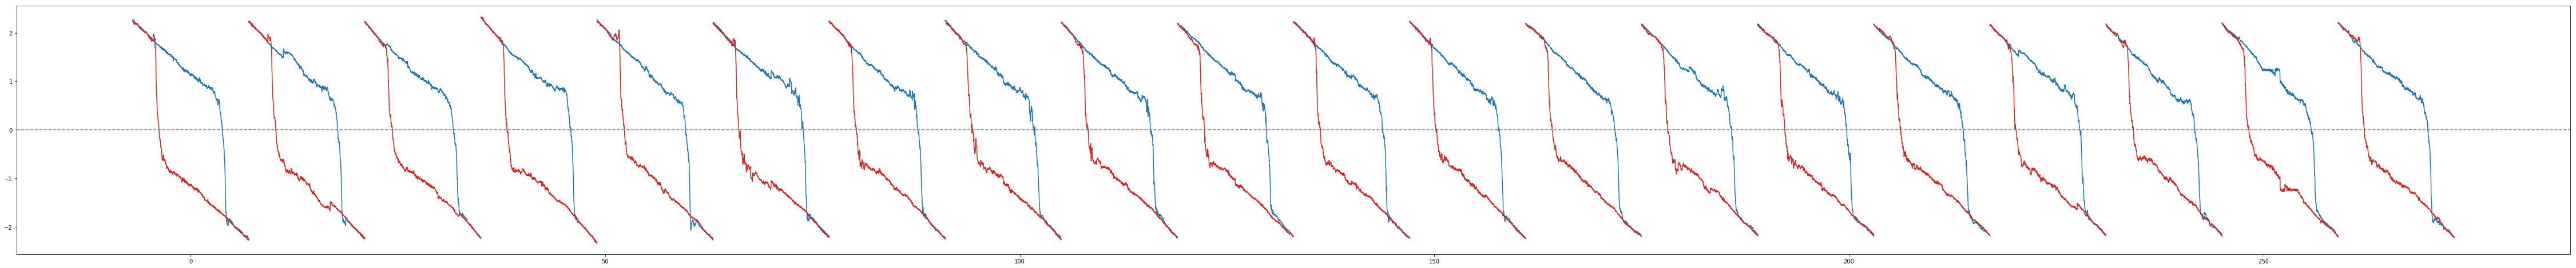

In [999]:
 all_together_now_shifted([['1647_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_0.0V_1.5K.txt'],
                              ['1800_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-1_-1.0V_1.5K.txt'],
                              ['1858_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-2_gain4_-1.0V_1.5K.txt'],
                              ['2001_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_1.5K.txt'],
                              ['1823_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.5_gain4_0.0V_1.5K.txt'],
                              ['1139_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt'],
                              ['1715_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt'],
                              ['1920_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4.5_gain4_0.0V_1.5K.txt'],
                              ['1240_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-5_gain4_0.0V_1.5K.txt'],
                              ['1338_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-6_gain4_0.0V_1.5K.txt'],
                              ['1438_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-7_gain4_0.0V_1.5K.txt'],
                              ['1535_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-8_gain4_0.0V_1.5K.txt'],
                              ['1809_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.5_gain4_0.0V_1.5K.txt'],
                              ['1709_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.25_gain4_presweep_0.0V_1.5K.txt'],
                              ['1907_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.75_gain4_0.0V_1.5K.txt'],
                              ['2005_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt'],
                              ['1100_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_1.5K.txt'],
                              ['1157_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.25_gain4_0.0V_1.5K.txt'],
                              ['1255_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.5_gain4_0.0V_1.5K.txt'],
                              ['1352_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.75_gain4_0.0V_1.5K.txt']],
                             ['TG0','TG-1','TG-2','TG-3','TG-3.5','TG-4','TG-4','TG-4.5','TG-5','TG-6','TG-7','TG-8','TG-3.5','TG-3.25','TG-3.75','TG-4','TG-3','TG-3.25','TG-3.5','TG-3.75'],
                             0,avgnumber=0)

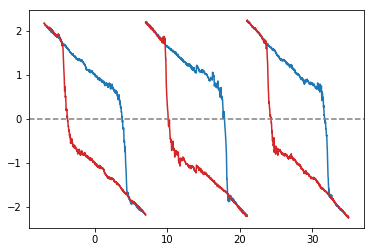

In [1030]:
 all_together_now_shifted([#['1647_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_0.0V_1.5K.txt'],
                              #['1800_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-1_-1.0V_1.5K.txt'],
                              #['1858_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-2_gain4_-1.0V_1.5K.txt'],
                              #['2001_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_1.5K.txt'],
                              ##['1100_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_1.5K.txt'],
                              #['1157_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.25_gain4_0.0V_1.5K.txt'],
                              #['1709_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.25_gain4_presweep_0.0V_1.5K.txt']],
                              #['1255_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.5_gain4_0.0V_1.5K.txt'],
                              #['1809_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.5_gain4_0.0V_1.5K.txt'],
                              #['1823_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.5_gain4_0.0V_1.5K.txt']],
                              #['1907_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.75_gain4_0.0V_1.5K.txt'],
                              #['1352_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.75_gain4_0.0V_1.5K.txt']],
                              ['2005_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt'],
                              ['1139_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt'],
                              ['1715_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt']],
                              #['1920_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4.5_gain4_0.0V_1.5K.txt'],
                              #['1240_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-5_gain4_0.0V_1.5K.txt'],
                              #['1338_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-6_gain4_0.0V_1.5K.txt'],
                              #['1438_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-7_gain4_0.0V_1.5K.txt'],
                              #['1535_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-8_gain4_0.0V_1.5K.txt']],
                          slopefit=0,avgnumber=0)

In [32]:
sro13_1p5_tg0=read_data_patchwork_averaging(['1647_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_0.0V_1.5K.txt'],0.17,sign=-1,avgnumber=20)

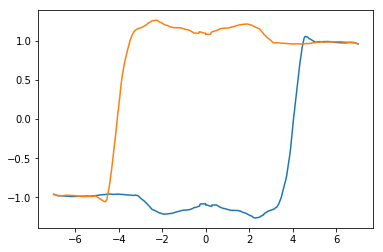

In [1364]:
sro13_1p5_tgm1=read_data_patchwork_averaging(['1800_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-1_-1.0V_1.5K.txt'],0.18,sign=-1,avgnumber=26)

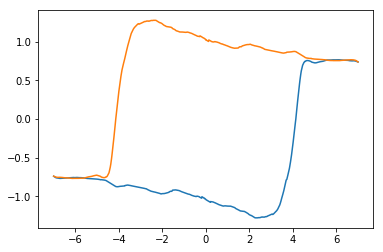

In [1358]:
sro13_1p5_tgm2=read_data_patchwork_averaging(['1858_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-2_gain4_-1.0V_1.5K.txt'],0.21,sign=-1,avgnumber=20)

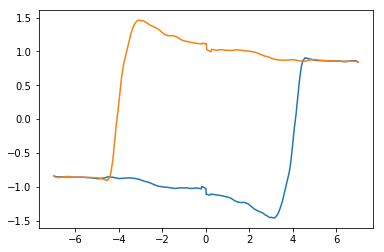

In [1366]:
sro13_1p5_tgm3=read_data_patchwork_averaging(['2001_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_1.5K.txt'],0.21,sign=-1,avgnumber=20)

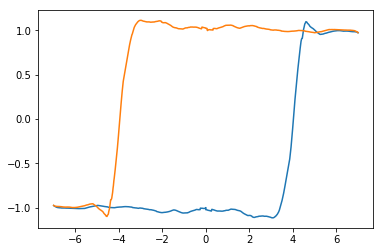

In [1369]:
sro13_1p5_tgm3p5=read_data_patchwork_averaging(['1823_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.5_gain4_0.0V_1.5K.txt'],0.18,sign=-1,avgnumber=25)

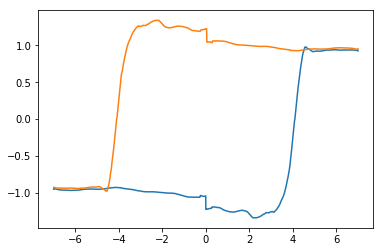

In [1370]:
sro13_1p5_tgm4=read_data_patchwork_averaging(['1139_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt'],0.18,sign=-1,avgnumber=25)

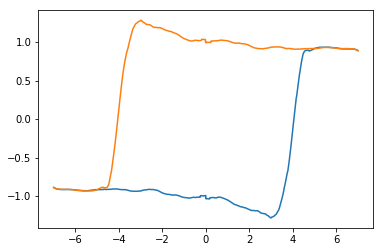

In [1371]:
sro13_1p5_tgm4_b1=read_data_patchwork_averaging(['1715_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt'],0.19,sign=-1,avgnumber=25)

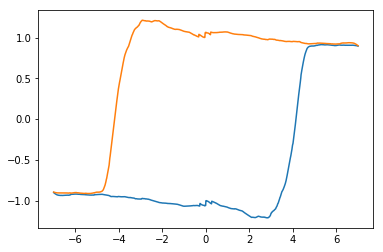

In [1372]:
sro13_1p5_tgm4p5=read_data_patchwork_averaging(['1920_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4.5_gain4_0.0V_1.5K.txt'],0.19,sign=-1,avgnumber=25)

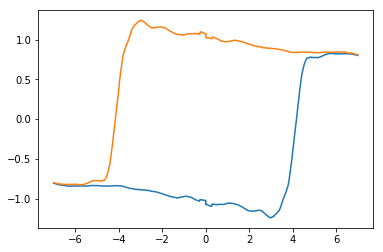

In [1373]:
sro13_1p5_tgm5=read_data_patchwork_averaging(['1240_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-5_gain4_0.0V_1.5K.txt'],0.2,sign=-1,avgnumber=25)

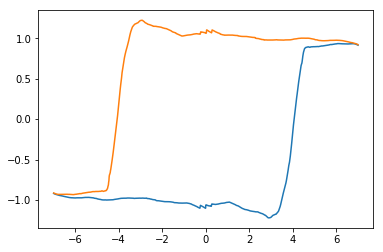

In [1375]:
sro13_1p5_tgm6=read_data_patchwork_averaging(['1338_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-6_gain4_0.0V_1.5K.txt'],0.18,sign=-1,avgnumber=25)

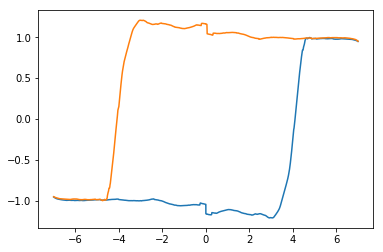

In [1377]:
sro13_1p5_tgm7=read_data_patchwork_averaging(['1438_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-7_gain4_0.0V_1.5K.txt'],0.18,sign=-1,avgnumber=25)

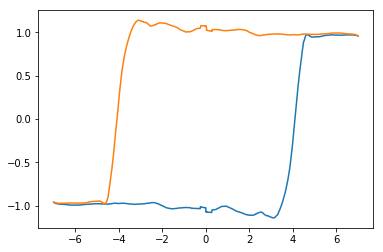

In [1378]:
sro13_1p5_tgm8=read_data_patchwork_averaging(['1535_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-8_gain4_0.0V_1.5K.txt'],0.18,sign=-1,avgnumber=25)

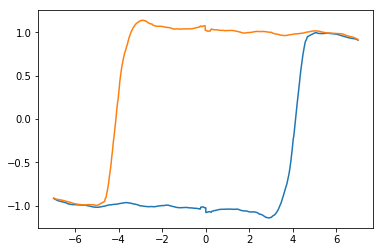

In [1387]:
sro13_1p5_tgm3p5_b1=read_data_patchwork_averaging(['1809_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.5_gain4_0.0V_1.5K.txt'],0.18,sign=-1,avgnumber=25)

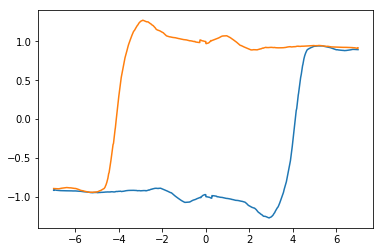

In [1388]:
sro13_1p5_tgm3p25=read_data_patchwork_averaging(['1709_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.25_gain4_presweep_0.0V_1.5K.txt'],0.18,sign=-1,avgnumber=25)

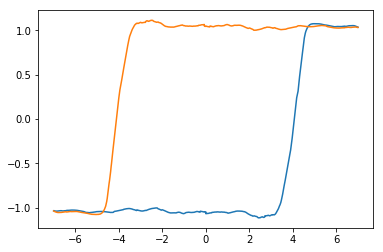

In [1389]:
sro13_1p5_tgm3p75=read_data_patchwork_averaging(['1907_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.75_gain4_0.0V_1.5K.txt'],0.16,sign=-1,avgnumber=25)

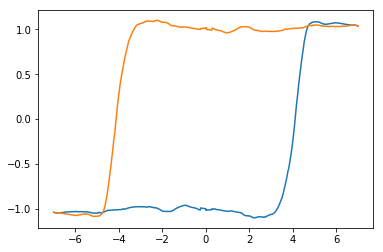

In [1390]:
sro13_1p5_tgm4_b2=read_data_patchwork_averaging(['2005_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt'],0.16,sign=-1,avgnumber=25)

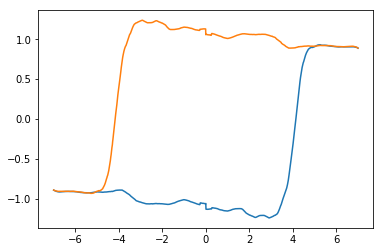

In [1391]:
sro13_1p5_tgm3_b1=read_data_patchwork_averaging(['1100_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_1.5K.txt'],0.18,sign=-1,avgnumber=25)

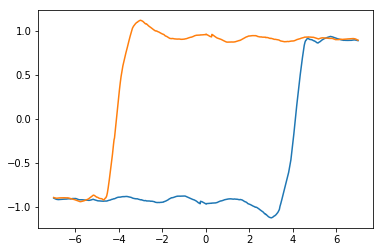

In [1392]:
sro13_1p5_tgm3p25_b1=read_data_patchwork_averaging(['1157_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.25_gain4_0.0V_1.5K.txt'],0.18,sign=-1,avgnumber=25)

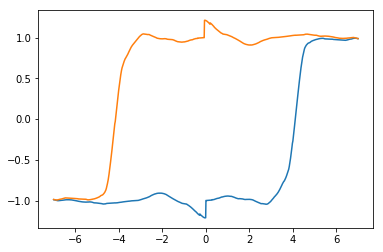

In [1395]:
sro13_1p5_tgm3p5_b2=read_data_patchwork_averaging(['1255_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.5_gain4_0.0V_1.5K.txt'],0.17,sign=-1,avgnumber=25)

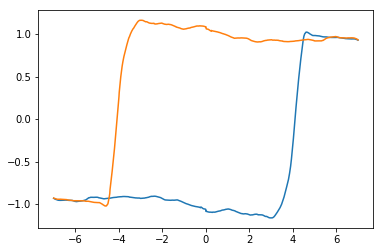

In [1397]:
sro13_1p5_tgm3p75_b1=read_data_patchwork_averaging(['1352_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.75_gain4_0.0V_1.5K.txt'],0.18,sign=-1,avgnumber=25)

0.16
slope 0.16


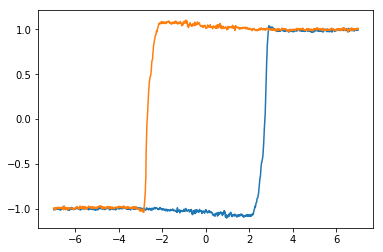

In [1236]:
sro13_10_tg0=read_data('1526_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_0_gain4_0.0V_10.0K.txt',0.16)

0.15
slope 0.15


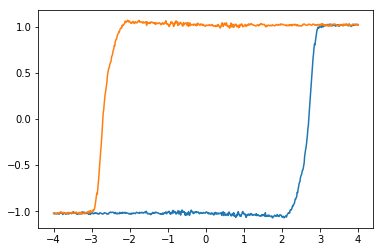

In [1241]:
sro13_10_tgm1=read_data('1623_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-1_gain4_0.0V_10.0K.txt',0.15)

0.15
slope 0.15


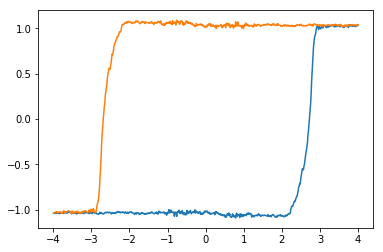

In [1244]:
sro13_10_tgm2=read_data('1656_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-2_gain4_0.0V_10.0K.txt',0.15)

0.15
slope 0.15


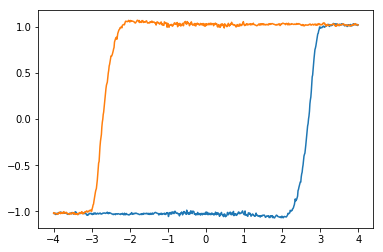

In [1246]:
sro13_10_tgm3=read_data('1733_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_10.0K.txt',0.15)

0.15
slope 0.15


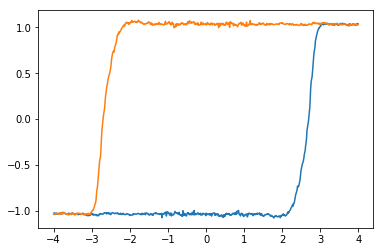

In [1295]:
sro13_10_tgm4=read_data('1837_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_10.0K.txt',0.15)

0.14
slope 0.14


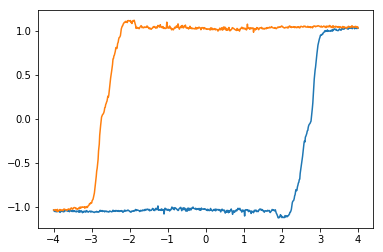

In [1249]:
sro13_10_tgm4_b1=read_data('1928_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_10.0K.txt',0.14)

0.16
slope 0.16


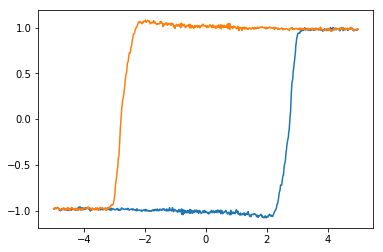

In [1252]:
sro13_10_tgm5=read_data('1622_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-5_0.0V_9.9K.txt',0.16)

0.16
slope 0.16


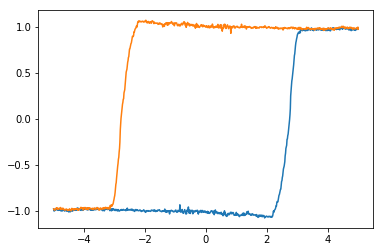

In [1254]:
sro13_10_tgm6=read_data('1706_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-6_0.0V_9.9K.txt',0.16)

0.15
slope 0.15


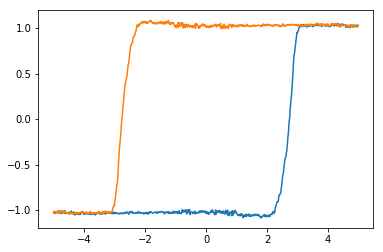

In [1255]:
sro13_10_tgm7=read_data('1751_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-7_0.0V_9.5K.txt',0.15)

0.16
slope 0.16


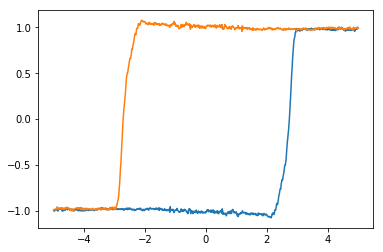

In [1257]:
sro13_10_tg5=read_data('1918_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG5_0.0V_9.5K.txt',0.16)

0.16
slope 0.16


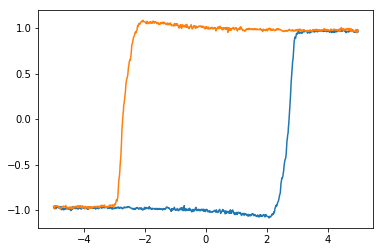

In [1259]:
sro13_10_tg6=read_data('2000_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG6_0.0V_9.7K.txt',0.16)

0.16
slope 0.16


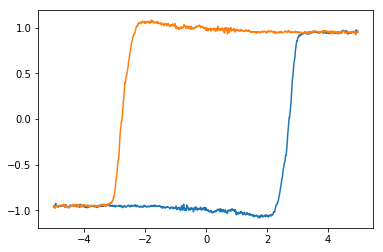

In [1261]:
sro13_10_tg7=read_data('2042_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG7_0.0V_9.1K.txt',0.16)

0.15
slope 0.15


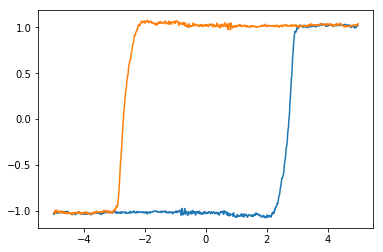

In [1262]:
sro13_10_tg8=read_data('2123_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG8_0.0V_9.7K.txt',0.15)

0.15
slope 0.15


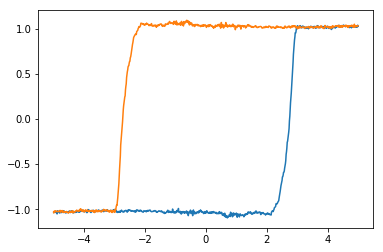

In [1263]:
sro13_10_tgm8=read_data('1836_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-8_0.0V_9.6K.txt',0.15)

15513.8094052
[] (array([], dtype=int64),)


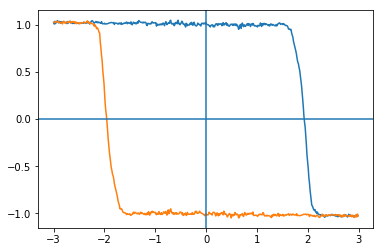

In [1298]:
sro13_20_tgm4=read_data_patchwork(['1148_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-4_0.0V_19.9K.txt','1159_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-4_0.0V_19.8K.txt'],-0.14)

0.14
slope 0.14


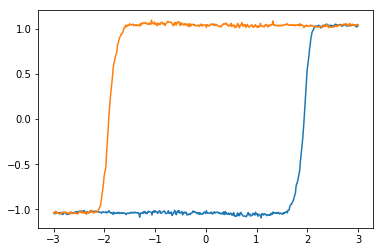

In [1299]:
sro13_20_tgm6=read_data('1235_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-6_0.0V_19.9K.txt',0.14)

0.13
slope 0.13


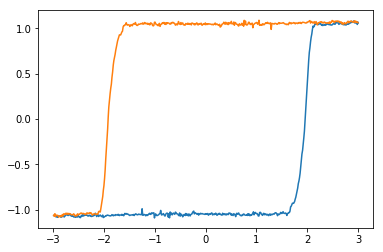

In [1300]:
sro13_20_tgm8=read_data('1306_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-8_0.0V_19.8K.txt',0.13)

0.14
slope 0.14


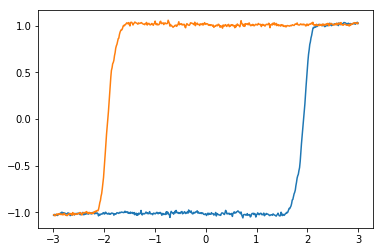

In [1301]:
sro13_20_tg6=read_data('1332_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG6_0.0V_19.9K.txt',0.14)

In [4]:
def read_data_flipsign(filename,ohe_antisym_prec=20,ohe_sym_prec=20):
    '''
    filename should be of the format 'filename.txt'
    '''
    data=pd.read_csv(filename,sep='\t')
    data.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
    
    def shave():
        B=[float(i) for i in data.B[2:]]
        Rxx=[float(i) for i in data.R_xx[2:]]
        Rxy=[-float(i) for i in data.R_xy[2:]]
        Thetaxy=[float(i) for i in data.Theta_xy[2:]]
        Thetaxx=[float(i) for i in data.Theta_xx[2:]]
        Thetaxy=[np.cos(np.deg2rad(i)) for i in Thetaxy]
        Thetaxx=[np.cos(np.deg2rad(i)) for i in Thetaxx]
        Rxy=[Rxy[i]*Thetaxy[i] for i in range(len(Rxy))] #muliplying by the phase
        Rxx=[Rxx[i]*Thetaxx[i] for i in range(len(Rxx))] #muliplying by the phase
        npl=np.array(B)
        #getting rid of zeroes
        #[npz]=np.where(npl==0)
        #getting rid of repeating points at the opposite ends of the sweep
        [nplmax]=np.where(npl==np.max(npl))
        if len(nplmax)!=0:
            indmid1=len(nplmax)//2 #the middle one, because why not
            indrep=np.delete(nplmax,indmid1)#list of indices where we're stuck at repeating 7
        else:
            indrep=[0]
        [nplmin]=np.where(npl==np.min(npl))
        if len(nplmin)!=0:
            indmid2=len(nplmin)//2 #the middle one, because why not
            indrepm=np.delete(nplmin,indmid2)#list of indices where we're stuck at repeating 7
        else:
            indrepm=[0]
        #let's make a superlist of all the indices we want to rid lB of
        indtodel=indrep#np.append(npz,indrep)
        indtodel=np.append(indtodel,indrepm)
        proc_B=np.delete(B,indtodel)
        proc_Rxx=np.delete(Rxx,indtodel)
        proc_Rxy=np.delete(Rxy,indtodel)
        proc_Rxy=np.flip(proc_Rxy,0)
        return proc_B,proc_Rxx,proc_Rxy
    
    proc_B,proc_Rxx,proc_Rxy=shave()
    
    def plot_B(x):
        fig, ax = plt.subplots()
        xaxis=range(len(x))
        ax.plot(xaxis,x)
        plt.yticks([])
        plt.show()
    def plot_res(x):
        fig, ax = plt.subplots()
        xaxis=proc_B
        ax.plot(xaxis,x)
        plt.yticks()
        plt.show()
        
        
    #plot_B(proc_B)
    #plot_res(proc_Rxx)
    #plot_res(proc_Rxy)
    
    
    def antisymmetrize(mat,proc_B=proc_B):
        [hi_point]=np.where(proc_B==np.max(proc_B))[0]
        [lo_point]=np.where(proc_B==np.min(proc_B))[0]
        [mid_point]=np.where(proc_B==0)
        mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)<3:
            ensure_init_0=np.array([0])
            proc_B_t=np.append(ensure_init_0,proc_B)
            proc_B=proc_B_t
            [hi_point]=np.where(proc_B==np.max(proc_B))[0]
            [lo_point]=np.where(proc_B==np.min(proc_B))[0]
            [mid_point]=np.where(proc_B==0)
            mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)==3: #only one 0 value in the middle: affects he down sweep
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            smol_hi_zero=mid[2]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[smol_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[smol_mid_zero:lo_point]
        if len(mid)==4: #only the down sweep is affected
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        if len(mid)>4:
            raise ValueError('mid is bigger than 4...')
        ##valid if we start w positive first!
        ub1=proc_B[lo_point:smol_hi_zero]
        ub2=proc_B[big_lo_zero:hi_point]
        u1=mat[lo_point:smol_hi_zero]
        u2=mat[big_lo_zero:hi_point]
        
        #we should interpolate chunk-by-chunk
        
        ub=np.append(ub1,ub2)
        db=np.append(db1,db2)
        
        if len(ub)>len(db):
            d1=np.flip(np.interp(ub2,np.flip(db1,0),np.flip(d1,0)),0)
            d2=np.flip(np.interp(ub1,np.flip(db2,0),np.flip(d2,0)),0)
            u=np.append(u1,u2)
            d=np.append(d1,d2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('db smoler')
            return ub,g
        if len(ub)<len(db):
            u1=np.interp(np.flip(db2,0),ub1,u1)
            u2=np.interp(np.flip(db1,0),ub2,u2)
            u=np.append(u1,u2)
            d=np.append(d1,d2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('ub smoler')
            return np.flip(db,0),g
        if len(ub)==len(db):
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('same')
            return ub,g#ub,u,db,d,len(ub)-len(db)
    
    def symmetrize(mat,proc_B=proc_B):
        [hi_point]=np.where(proc_B==np.max(proc_B))[0]
        [lo_point]=np.where(proc_B==np.min(proc_B))[0]
        [mid_point]=np.where(proc_B==0)
        mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)<3:
            ensure_init_0=np.array([0])
            proc_B_t=np.append(ensure_init_0,proc_B)
            proc_B=proc_B_t
            [hi_point]=np.where(proc_B==np.max(proc_B))[0]
            [lo_point]=np.where(proc_B==np.min(proc_B))[0]
            [mid_point]=np.where(proc_B==0)
            mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)==3: #only one 0 value in the middle: affects he down sweep
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            smol_hi_zero=mid[2]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[smol_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[smol_mid_zero:lo_point]
        if len(mid)==4: #only the down sweep is affected
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        ##valid if we start w positive first!
        ub1=proc_B[lo_point:smol_hi_zero]
        ub2=proc_B[big_lo_zero:hi_point]
        u1=mat[lo_point:smol_hi_zero]
        u2=mat[big_lo_zero:hi_point]
        
        #we should interpolate chunk-by-chunk
        
        ub=np.append(ub1,ub2)
        db=np.append(db1,db2)
        
        if len(ub)>len(db):
            d1=np.flip(np.interp(ub2,np.flip(db1,0),np.flip(d1,0)),0)
            d2=np.flip(np.interp(ub1,np.flip(db2,0),np.flip(d2,0)),0)
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            d=np.flip(d,0)
            g=np.add(u,d)/2
            #print('ub bigger')
            return ub,g
        if len(ub)<len(db):
            u1=np.interp(np.flip(db2,0),ub1,u1)
            u2=np.interp(np.flip(db1,0),ub2,u2)
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            d=np.flip(d,0)
            g=np.add(u,d)/2
            #print('db bigger')
            return np.flip(db,0),g
        if len(ub)==len(db):
            d=np.append(d1,d2)
            d=np.flip(d,0)
            u=np.append(u1,u2)
            g=np.add(u,d)/2
            #print('same')
            return ub,g#ub,u,db,d,len(ub)-len(db)
        
    
    def plot_antisym(mat):
        fig, ax = plt.subplots()
        xaxis,x=antisymmetrize(mat)
        ax.plot(xaxis,x)
        ax.plot(np.flip(xaxis,0),-x)
        plt.show()
    
    
    
    def remove_OHE_antisym(mat):
        rawx,rawy=antisymmetrize(mat)
        [a1,b1]=np.polyfit(rawx[0:ohe_antisym_prec],rawy[0:ohe_antisym_prec],1)
        subtract_vector=np.array([a1*i for i in rawx])
        no_ohe=np.subtract(rawy,subtract_vector)
        print(a1)
        
        
        
        return rawx,no_ohe
    
    def remove_OHE_sym(mat):
        rawx,rawy=symmetrize(mat)
        [a,b]=np.polyfit(rawx[-ohe_sym_prec:-1],rawy[-ohe_sym_prec:-1],1)
        subtract_vector=np.array([a*i for i in rawx])
        no_ohe=np.subtract(rawy,subtract_vector)
        return rawx,no_ohe,a1
    
    def plot_sym_rem(mat):
        fig, ax = plt.subplots()
        xaxis,x=remove_OHE_sym(mat)
        ax.plot(xaxis,x)
        ax.plot(-xaxis,x)
        plt.show()
    def plot_sym(mat):
        fig, ax = plt.subplots()
        xaxis,x=symmetrize(mat)
        ax.plot(xaxis,x)
        ax.plot(-xaxis,x)
        plt.show()
        
    #plot_sym(proc_Rxy)
    #plot_sym_rem(proc_Rxy)
    
    
    def conductance():
        xyub,rxy_vec,a1=remove_OHE_antisym(proc_Rxy)
        xxub,rxx_vec=symmetrize(proc_Rxx)
        if len(rxy_vec)!=len(rxx_vec):
            raise ValueError('not the same length...')
        conductance_vec=np.array([rxy_vec[i]/(rxx_vec[i])**2 for i in range(len(rxy_vec))])
        lh=sum(conductance_vec[0:ohe_antisym_prec])/ohe_antisym_prec
        print('loop height:',lh  )
        o400=np.array([int(i) for i in range(1,400)])
        
        
        arrau=abs(lh-(conductance_vec[0]))/abs(lh-(conductance_vec[o400]))
        bb=np.where((0.99<arrau) & (arrau<1.001))
        print(conductance_vec[bb],bb)
        
        def plot_():
            fig, ax = plt.subplots()
            xaxis=xyub
            #x=np.array(conductance_vec)
            x=np.array(rxy_vec)
            ax.plot(xaxis,x)
            ax.plot(np.flip(xaxis,0),-x)
            plt.show()
        plot_()
        return a1,lh
    return conductance()#antisymmetrize(proc_Rxy)

15515.3061652
[ -4.23297807e-09] (array([18]),)


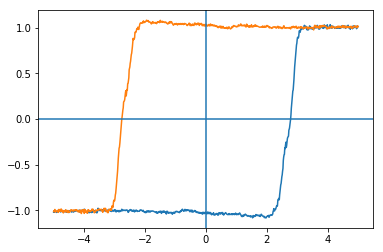

In [1302]:
sro13_10_tg8_b1=read_data_patchwork(['2211_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG8_8.035729V_9.9K.txt'],0.16)

15520.6020586
[ -4.28585350e-09] (array([21]),)


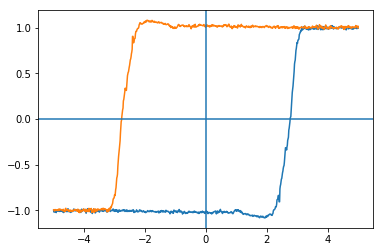

In [1303]:
sro13_10_tg8_b2=read_data_patchwork(['2046_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG8_8.040324V_9.9K.txt'],0.16)

15521.3347074
[] (array([], dtype=int64),)


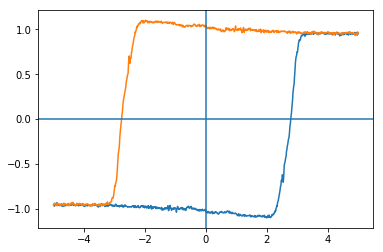

In [1304]:
sro13_10_tg9=read_data_patchwork(['2003_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG9_9.031675V_9.9K.txt'],0.17)

15522.2592655
[ -4.44427865e-09] (array([56]),)


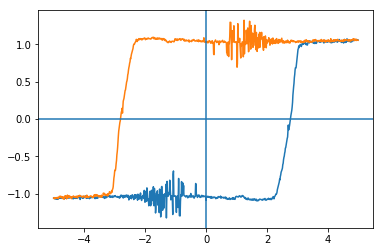

In [1305]:
sro13_10_tg10=read_data_patchwork(['1920_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG10_hyst_10.03535V_9.9K.txt'],0.15)

15522.4511976
[] (array([], dtype=int64),)


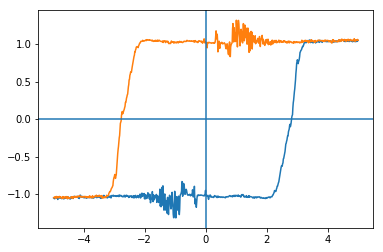

In [1306]:
sro13_10_tg10_b1=read_data_patchwork(['1803_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG10_10.03114V_9.9K.txt'],0.15)

In [173]:
sro13_10_tg10_b2=read_data_patchwork_averaging(['2129_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG11_11.03243V_9.9K.txt'],0.16,-1)

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:343: RuntimeWarning: divide by zero encountered in double_scalars
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:343: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:347: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:347: RuntimeWarning: invalid value encountered in subtract
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:348: RuntimeWarning: invalid value encountered in greater
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:348: RuntimeWarning: invalid value encountered in less
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:352: RuntimeWarning: invalid value encountered in less
/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:352: RuntimeWarning: invalid value encountered in greater


ZeroDivisionError: division by zero

In [1432]:
def all_together_now_shifted(filelist,signs,slopefit,avgnumber):
    h=[(read_data_patchwork_averaging(filelist[i],slopefit=slopefit,sign=signs[i],avgnumber=avgnumber)) for i in range(len(filelist))]
    fig,ax=plt.subplots(figsize=(30,7))
    for i in range(len(h)):
        ax.plot(h[i][0][0]+10*i,h[i][0][1],color='tab:blue')
        ax.plot(-h[i][0][0]+10*i,-h[i][0][1],color='tab:red')
    plt.axhline(0,linestyle='--',color='gray')
    plt.savefig('10_monoloops_apb4.eps', format='eps',bbox_inches='tight')
    plt.show()

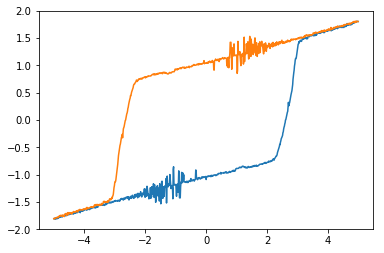

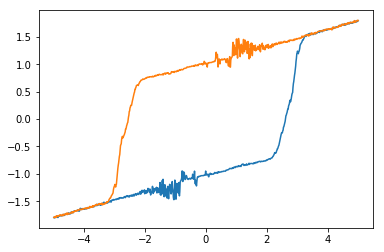

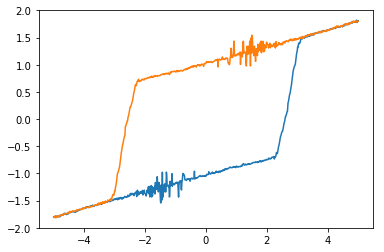

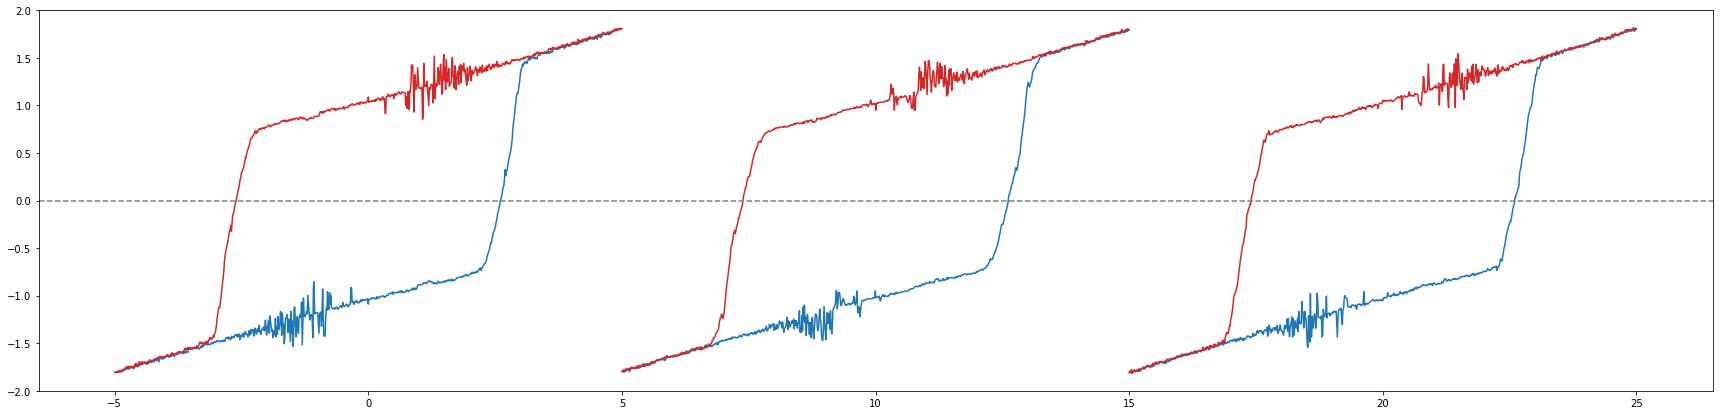

In [1433]:
all_together_now_shifted([['1920_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG10_hyst_10.03535V_9.9K.txt'],
                         ['1803_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG10_10.03114V_9.9K.txt'],
                         ['2129_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG11_11.03243V_9.9K.txt']],
                         [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],0,avgnumber=0)

In [192]:
def coercivity_w_tg(filelistone,filelisttwo,filelistthree):
    one=[(read_data_patchwork_averaging(filelistone[i],slopefit=0,sign=1,avgnumber=0)) for i in range(len(filelistone))]
    two=[(read_data_patchwork_averaging(filelisttwo[i],slopefit=0,sign=1,avgnumber=0)) for i in range(len(filelisttwo))]
    three=[(read_data_patchwork_averaging(filelistthree[i],slopefit=0,sign=1,avgnumber=0)) for i in range(len(filelistthree))]
    fig,ax=plt.subplots()
    plt.scatter(np.array([0,-1,-2,-3,-4,-4]),one)
    plt.scatter(np.array([-5,-6,-7,5,6,7,8]),two)
    plt.scatter(np.array([-8,8,8,9,10,10,11]),three)
    #plt.plot(np.array([0,-1,-2,-3,-4,-4]),one)
    #plt.plot(np.array([-5,-6,-7,5,6,7,8]),two)
    #plt.plot(np.array([-8,8,8,9,10,10,11]),three)

    ax.set_ylabel('Coercive field [ T ]')#,color='tab:blue')
    ax.yaxis.label.set_size(18)
    ax.set_xlabel('Top gate [ V ]')
    ax.xaxis.label.set_size(18)
    plt.show

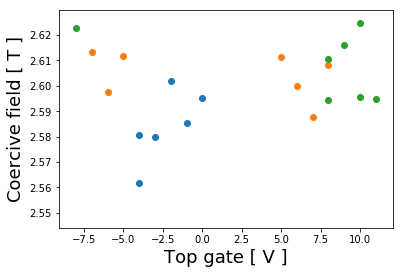

In [193]:
coercivity_w_tg([['1526_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_0_gain4_0.0V_10.0K.txt'],
                         ['1623_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-1_gain4_0.0V_10.0K.txt'],
                         ['1656_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-2_gain4_0.0V_10.0K.txt'],
                         ['1733_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_10.0K.txt'],
                         ['1837_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_10.0K.txt'],
                         ['1928_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_10.0K.txt']],
                 [['1622_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-5_0.0V_9.9K.txt'],
                         ['1706_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-6_0.0V_9.9K.txt'],
                         ['1751_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-7_0.0V_9.5K.txt'],
                         ['1918_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG5_0.0V_9.5K.txt'],
                         ['2000_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG6_0.0V_9.7K.txt'],
                         ['2042_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG7_0.0V_9.1K.txt'],
                         ['2123_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG8_0.0V_9.7K.txt']],
               [['1836_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-8_0.0V_9.6K.txt'],
                         ['2211_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG8_8.035729V_9.9K.txt'],
                         ['2046_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG8_8.040324V_9.9K.txt'],
                         ['2003_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG9_9.031675V_9.9K.txt'],
                         ['1920_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG10_hyst_10.03535V_9.9K.txt'],
                         ['1803_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG10_10.03114V_9.9K.txt'],
                         ['2129_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG11_11.03243V_9.9K.txt']])

In [ ]:
all_together_now_shifted([['1526_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_0_gain4_0.0V_10.0K.txt'],
                         ['1623_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-1_gain4_0.0V_10.0K.txt'],
                         ['1656_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-2_gain4_0.0V_10.0K.txt'],
                         ['1733_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_10.0K.txt'],
                         ['1837_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_10.0K.txt'],
                         ['1928_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_10.0K.txt'],
                         ['1622_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-5_0.0V_9.9K.txt'],
                         ['1706_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-6_0.0V_9.9K.txt'],
                         ['1751_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-7_0.0V_9.5K.txt'],
                         ['1918_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG5_0.0V_9.5K.txt'],
                         ['2000_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG6_0.0V_9.7K.txt'],
                         ['2042_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG7_0.0V_9.1K.txt'],
                         ['2123_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG8_0.0V_9.7K.txt'],
                         ['1836_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-8_0.0V_9.6K.txt'],
                         ['2211_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG8_8.035729V_9.9K.txt'],
                         ['2046_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG8_8.040324V_9.9K.txt'],
                         ['2003_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG9_9.031675V_9.9K.txt'],
                         ['1920_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG10_hyst_10.03535V_9.9K.txt'],
                         ['1803_bSR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG10_10.03114V_9.9K.txt'],
                         ['2129_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG11_11.03243V_9.9K.txt']],
                         [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1,1,1,1],0,avgnumber=0)

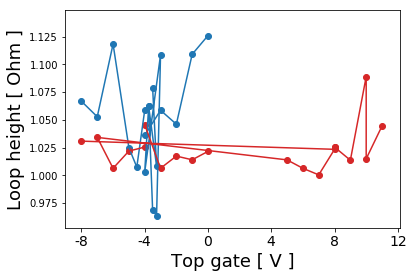

In [165]:
plot_loop_height_and_Hall_slope([['1647_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_0.0V_1.5K.txt'],
                              ['1800_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-1_-1.0V_1.5K.txt'],
                              ['1858_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-2_gain4_-1.0V_1.5K.txt'],
                              ['2001_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_1.5K.txt'],
                              ['1715_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt']],
                                
                              [['1139_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt'],
                               ['1920_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4.5_gain4_0.0V_1.5K.txt'],
                              ['1240_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-5_gain4_0.0V_1.5K.txt'],
                              ['1338_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-6_gain4_0.0V_1.5K.txt'],
                              ['1438_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-7_gain4_0.0V_1.5K.txt'],
                              ['1535_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-8_gain4_0.0V_1.5K.txt']],
                              [['1809_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.5_gain4_0.0V_1.5K.txt'],
                              ['1709_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.25_gain4_presweep_0.0V_1.5K.txt'],
                              ['1907_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.75_gain4_0.0V_1.5K.txt'],
                              ['2005_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_1.5K.txt'],
                              ['1100_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_1.5K.txt'],
                              ['1157_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.25_gain4_0.0V_1.5K.txt'],
                              ['1255_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.5_gain4_0.0V_1.5K.txt'],
                              ['1352_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3.75_gain4_0.0V_1.5K.txt']],
                                
                                [['1526_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_0_gain4_0.0V_10.0K.txt'],
                         ['1623_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-1_gain4_0.0V_10.0K.txt'],
                         ['1656_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-2_gain4_0.0V_10.0K.txt'],
                         ['1733_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-3_gain4_0.0V_10.0K.txt'],
                         ['1837_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_10.0K.txt']
                         ],
                 [['1928_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_1.5K_7_TG_-4_gain4_0.0V_10.0K.txt'],
                  ['1622_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-5_0.0V_9.9K.txt'],
                         ['1706_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-6_0.0V_9.9K.txt'],
                         ['1751_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-7_0.0V_9.5K.txt'],
                         ['1918_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG5_0.0V_9.5K.txt'],
                         ['2000_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG6_0.0V_9.7K.txt'],
                         ['2042_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG7_0.0V_9.1K.txt'],
                         ['2123_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG8_0.0V_9.7K.txt'],
                  ['1836_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall4-9_TG-8_0.0V_9.6K.txt']
                 ],
               [
                         ['2211_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG8_8.035729V_9.9K.txt'],
                         ['2046_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG8_8.040324V_9.9K.txt'],
                         ['2003_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG9_9.031675V_9.9K.txt'],
                         ['1920_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG10_hyst_10.03535V_9.9K.txt'],
                         ['1803_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG10_10.03114V_9.9K.txt'],
                         ['2129_SR013_MR_Hall_Dev2_I7-3_V5-4_VHall5-8_TG11_11.03243V_9.9K.txt']],
                          [0.17,0.18,0.21,0.21,0.19],[0.18,0.19,0.2,0.18,0.18,0.18],[0.18,0.18,0.16,0.16,0.18,0.18,0.18,0.18],
                                [0.11,0.15,0.15,0.15,0.15],[0.14,0.16,0.16,0.15,0.16,0.16,0.16,0.15,0.15],[0.16,0.16,0.17,0.15,0.15,0.16]
                               )

In [162]:
#SR013 results: resistivity height (only rxy)
import matplotlib.pyplot as plt
def plot_loop_height_and_Hall_slope(filelist1,filelist2,filelist3,filelist4,filelist5,filelist6,slopefit1,slopefit2,slopefit3,slopefit4,slopefit5,slopefit6):
    rxx_xaxis_1p5_1=[(read_data_patchwork_averaging(filelist1[i],slopefit=slopefit1[i],sign=1,avgnumber=0))[0][1] for i in range(len(filelist1))]
    rxx_xaxis_1p5_2=[(read_data_patchwork_averaging(filelist2[i],slopefit=slopefit2[i],sign=1,avgnumber=0))[0][1] for i in range(len(filelist2))]
    rxx_xaxis_1p5_3=[(read_data_patchwork_averaging(filelist3[i],slopefit=slopefit3[i],sign=1,avgnumber=0))[0][1] for i in range(len(filelist3))]
    
    rxx_xaxis_10_1=[(read_data_patchwork_averaging(filelist4[i],slopefit=slopefit4[i],sign=1,avgnumber=0))[0][1] for i in range(len(filelist4))]
    rxx_xaxis_10_2=[(read_data_patchwork_averaging(filelist5[i],slopefit=slopefit5[i],sign=1,avgnumber=0))[0][1] for i in range(len(filelist5))]
    rxx_xaxis_10_3=[(read_data_patchwork_averaging(filelist6[i],slopefit=slopefit6[i],sign=-1,avgnumber=0))[0][1] for i in range(len(filelist6))]
        
    
    
    tg_xaxis_1p5_1=[0,-1,-2,-3,-4] 
    tg_xaxis_1p5_2= [-4,-4.5,-5,-6,-7,-8] 
    tg_xaxis_1p5_3=[-3.5,-3.25,-3.75,-4,-3,-3.25,-3.5,-3.75]
    
    tg_xaxis_10_1=[0,-1,-2,-3,-4]
    tg_xaxis_10_2=[-4,-5,-6,-7,5,6,7,8,-8]
    tg_xaxis_10_3=[8,8,9,10,10,11]
        
    #tg_xaxis_20=[-4,-6,-8,6]
    
#     loop_height_1p5_1=[sro13_1p5_tg0[0][1],sro13_1p5_tgm1[0][1],sro13_1p5_tgm2[0][1],sro13_1p5_tgm3[0][1],sro13_1p5_tgm3p5[0][1],sro13_1p5_tgm4[0][1] ]
#     loop_height_1p5_2=[sro13_1p5_tgm4_b1[0][1],sro13_1p5_tgm4p5[0][1],sro13_1p5_tgm5[0][1],sro13_1p5_tgm6[0][1],sro13_1p5_tgm7[0][1],sro13_1p5_tgm8[0][1] ]
#     loop_height_1p5_3=[sro13_1p5_tgm3p5_b1[0][1],sro13_1p5_tgm3p25[0][1],sro13_1p5_tgm3p75[0][1],sro13_1p5_tgm4_b2[0][1],sro13_1p5_tgm3_b1[0][1],sro13_1p5_tgm3p25_b1[0][1],sro13_1p5_tgm3p5_b2[0][1],sro13_1p5_tgm3p75_b1[0][1] ]
#     loop_height_1p5=np.array(loop_height_1p5_1+loop_height_1p5_2+loop_height_1p5_3)
    
#     loop_height_10_1=[sro13_10_tg0[0][1],sro13_10_tgm1[0][1],sro13_10_tgm2[0][1],sro13_10_tgm3[0][1],sro13_10_tgm4[0][1]]
#     loop_height_10_2=[sro13_10_tgm4[0][1],sro13_10_tgm5[0][1],sro13_10_tgm6[0][1],sro13_10_tgm7[0][1],sro13_10_tgm8[0][1]]
#     loop_height_10_3=[sro13_10_tg8[0][1],sro13_10_tg8[0][1],sro13_10_tg9[0][1],sro13_10_tg10[0][1],sro13_10_tg10_b1[0][1],sro13_10_tg10_b2[0][1]]

#     loop_height_10=np.array(loop_height_10_1+loop_height_10_2+loop_height_10_3)
    
#     #loop_height_20=np.array([sro13_20_tgm4[1],sro13_20_tgm6[1],sro13_20_tgm8[1],sro13_20_tg6[1]])
    
#     hall_slope_1p5_1=[sro13_1p5_tg0[0][0],sro13_1p5_tgm1[0][0],sro13_1p5_tgm2[0][0],sro13_1p5_tgm3[0][0],sro13_1p5_tgm3p5[0][0],sro13_1p5_tgm4[0][0]]
#     hall_slope_1p5_2=[sro13_1p5_tgm4_b1[0][0],sro13_1p5_tgm4p5[0][0],sro13_1p5_tgm5[0][0],sro13_1p5_tgm6[0][0],sro13_1p5_tgm7[0][0],sro13_1p5_tgm8[0][0]]
#     hall_slope_1p5_3=[sro13_1p5_tgm3p5_b1[0][0],sro13_1p5_tgm3p25[0][0],sro13_1p5_tgm3p75[0][0],sro13_1p5_tgm4_b2[0][0],sro13_1p5_tgm3_b1[0][0],sro13_1p5_tgm3p25_b1[0][0],sro13_1p5_tgm3p5_b2[0][0],sro13_1p5_tgm3p75_b1[0][0]]
#     hall_slope_1p5=np.array( hall_slope_1p5_1+ hall_slope_1p5_2+ hall_slope_1p5_3)
    
#     hall_slope_10_1=[sro13_10_tg0[0][0],sro13_10_tgm1[0][0],sro13_10_tgm2[0][0],sro13_10_tgm3[0][0],sro13_10_tgm4[0][0]]
#     hall_slope_10_2=[sro13_10_tgm4[0][0],sro13_10_tgm5[0][0],sro13_10_tgm6[0][0],sro13_10_tgm7[0][0],sro13_10_tg5[0][0],sro13_10_tg6[0][0],sro13_10_tg7[0][0],sro13_10_tg8[0][0],sro13_10_tgm8[0][0]]
#     hall_slope_10_3=[sro13_10_tg8[0][0],sro13_10_tg8[0][0],sro13_10_tg9[0][0],sro13_10_tg10[0][0],sro13_10_tg10_b1[0][0],sro13_10_tg10_b2[0][0]]
#     hall_slope_10=np.array( hall_slope_10_1+ hall_slope_10_2+ hall_slope_10_3)
    
    #hall_slope_20=np.array([sro13_20_tgm4[0],sro13_20_tgm6[0],sro13_20_tgm8[0],sro13_20_tg6[0]])
    
    fig, ax = plt.subplots()
    ax.scatter(tg_xaxis_1p5_1,rxx_xaxis_1p5_1,color='tab:blue')
    ax.scatter(tg_xaxis_1p5_2,rxx_xaxis_1p5_2,color='tab:blue')
    ax.scatter(tg_xaxis_1p5_3,rxx_xaxis_1p5_3,color='tab:blue')
    ax.plot(tg_xaxis_1p5_1,rxx_xaxis_1p5_1,color='tab:blue')
    ax.plot(tg_xaxis_1p5_2,rxx_xaxis_1p5_2,color='tab:blue')
    ax.plot(tg_xaxis_1p5_3,rxx_xaxis_1p5_3,color='tab:blue')
    #ax2=ax.twinx()
    ax.scatter(tg_xaxis_10_1,rxx_xaxis_10_1,color='tab:red')
    ax.scatter(tg_xaxis_10_2,rxx_xaxis_10_2,color='tab:red')
    ax.scatter(tg_xaxis_10_3,rxx_xaxis_10_3,color='tab:red')
    ax.plot(tg_xaxis_10_1,rxx_xaxis_10_1,color='tab:red')
    ax.plot(tg_xaxis_10_2,rxx_xaxis_10_2,color='tab:red')
    ax.plot(tg_xaxis_10_3,rxx_xaxis_10_3,color='tab:red')
    ax.set_ylabel('Loop height [ Ohm ]')#,color='tab:blue')
    ax.yaxis.label.set_size(18)
    ax.set_xlabel('Top gate [ V ]')
    ax.xaxis.label.set_size(18)
    #ax.tick_params(axis='y', labelcolor='tab:blue')
    #ax2.tick_params(axis='y', labelcolor='tab:red')
    
    ax.xaxis.set_ticks([-8,-4,0,4,8,12])
    ax.xaxis.set_ticklabels([-8,-4,0,4,8,12],fontsize=14)
    
#     ax.yaxis.set_ticks([0.1,0.15,0.2])
#     ax.yaxis.set_ticklabels([0.1,0.15,0.2],fontsize=14)
    
#     ax2.yaxis.set_ticks([3895,3893,3891])
#     ax2.yaxis.set_ticklabels([3895,3893,3891],fontsize=14)
    

    #plt.ylim((np.min(loop_height_1p5),np.max(loop_height_1p5) ))
    #plt.title("1p5 loop")
#     plt.show()
    
#     fig, ax = plt.subplots()
#     plt.scatter(tg_xaxis_10_1,rxx_xaxis_10_1)
#     plt.scatter(tg_xaxis_10_2,rxx_xaxis_10_2)
#     plt.scatter(tg_xaxis_10_3,rxx_xaxis_10_3)
#     ax.set_ylabel('Sheet resistance [ Ohm ]')#,color='tab:blue')
#     ax.yaxis.label.set_size(18)
#     ax.set_xlabel('Top gate [ V ]')
#     ax.xaxis.label.set_size(18)

    #plt.ylim((np.min(loop_height_1p5),np.max(loop_height_1p5) ))
    #plt.title("1p5 loop")
    plt.show()
    
    

    
# #     fig, ax = plt.subplots()
# #     plt.scatter(tg_xaxis_1p5_1,loop_height_1p5_1)
# #     plt.scatter(tg_xaxis_1p5_2,loop_height_1p5_2)
# #     plt.scatter(tg_xaxis_1p5_3,loop_height_1p5_3)
# # #     plt.plot(tg_xaxis_1p5_1,loop_height_1p5_1)
# # #     plt.plot(tg_xaxis_1p5_2,loop_height_1p5_2)
# # #     plt.plot(tg_xaxis_1p5_3,loop_height_1p5_3)
# #     ax.set_ylabel('Rxy [ Ohm ]')#,color='tab:blue')
# #     ax.yaxis.label.set_size(18)
# #     ax.set_xlabel('Top gate [ V ]')
# #     ax.xaxis.label.set_size(18)
# #     plt.ylim((np.min(loop_height_1p5)-0.1,np.max(loop_height_1p5) +0.1))
# #     plt.title("1p5 loop")
    
# #     plt.show()
#     fig, ax = plt.subplots()
#     plt.scatter(tg_xaxis_10_1,loop_height_10_1)
#     plt.scatter(tg_xaxis_10_2,loop_height_10_2)
#     plt.plot(tg_xaxis_10_1,loop_height_10_1)
#     plt.plot(tg_xaxis_10_2,loop_height_10_2)
# #    plt.scatter(tg_xaxis_10_3,loop_height_10_3)
# #     plt.plot(tg_xaxis_10_1,loop_height_10_1)
# #     plt.plot(tg_xaxis_10_2,loop_height_10_2)
# #     plt.plot(tg_xaxis_10_3,loop_height_10_3)
# #    plt.scatter(tg_xaxis_1p5_1,loop_height_1p5_1)
# #    plt.scatter(tg_xaxis_1p5_2,loop_height_1p5_2)
# #    plt.plot(tg_xaxis_1p5_1,loop_height_1p5_1)
# #    plt.plot(tg_xaxis_1p5_2,loop_height_1p5_2)
# #     plt.scatter(tg_xaxis_1p5_3,loop_height_1p5_3)
#     ax.set_ylabel('Rxy [ Ohm ]')#,color='tab:blue')
#     ax.yaxis.label.set_size(18)
#     ax.set_xlabel('Top gate [ V ]')
#     ax.xaxis.label.set_size(18)
#     #plt.ylim((np.min(loop_height_10)-0.01,np.max(loop_height_10)+0.01 ))
#     #plt.title("10 loop")
#     plt.show()
# #     fig, ax = plt.subplots()
# #     plt.scatter(tg_xaxis_20,loop_height_20)
# #     plt.xlabel("top gate [V]")
# #     plt.ylabel("loop height [ohm e-8]")
# #     plt.ylim((np.min(loop_height_20),np.max(loop_height_20) ))
# #     plt.title("20 loop")
# #     plt.show()
# #     fig, ax = plt.subplots()
# #     plt.scatter(tg_xaxis_1p5_1,hall_slope_1p5_1)
# #     plt.scatter(tg_xaxis_1p5_2,hall_slope_1p5_2)
# #     plt.scatter(tg_xaxis_1p5_3,hall_slope_1p5_3)
# #     plt.plot(tg_xaxis_1p5_1,hall_slope_1p5_1)
# #     plt.plot(tg_xaxis_1p5_2,hall_slope_1p5_2)
# #     plt.plot(tg_xaxis_1p5_3,hall_slope_1p5_3)
# #     ax.set_ylabel('Rxy [ Ohm ]')#,color='tab:blue')
# #     ax.yaxis.label.set_size(18)
# #     ax.set_xlabel('Top gate [ V ]')
# #     ax.xaxis.label.set_size(18)
# #     plt.title("1p5 slope")
# #     plt.show()
# #     fig, ax = plt.subplots()
# #     plt.scatter(tg_xaxis_10_1,hall_slope_10_1)
# #     plt.scatter(tg_xaxis_10_2,hall_slope_10_2)
# #     plt.scatter(tg_xaxis_10_3,hall_slope_10_3)
# #     plt.plot(tg_xaxis_10_1,hall_slope_10_1)
# #     plt.plot(tg_xaxis_10_2,hall_slope_10_2)
# #     plt.plot(tg_xaxis_10_3,hall_slope_10_3)
# #     ax.set_ylabel('Rxy [ Ohm ]')#,color='tab:blue')
# #     ax.yaxis.label.set_size(18)
# #     ax.set_xlabel('Top gate [ V ]')
# #     ax.xaxis.label.set_size(18)
# #     plt.ylim((np.min(hall_slope_10)-0.001,np.max(hall_slope_10)+0.001 ))
# #     #plt.title("10 slope")
# #     plt.show()
# #     fig, ax = plt.subplots()
# #     ax.scatter(tg_xaxis_20,hall_slope_20)
# #     plt.xlabel("top gate [V]")
# #     plt.ylabel("OHE slope [ohm e-8]")
# #     plt.title("20 slope")
# #     plt.show()


In [55]:
def all_together_now_shifted(filelist,signs,slopefit,avgnumber):
    h=[(read_data_patchwork_averaging(filelist[i],slopefit=slopefit,sign=signs[i],avgnumber=avgnumber)) for i in range(len(filelist))]
    fig,ax=plt.subplots(figsize=(30,7))
    for i in range(len(h)):
        ax.plot(h[i][0][0]+3*i,h[i][0][1],color='tab:blue')
        ax.plot(-h[i][0][0]+3*i,-h[i][0][1],color='tab:red')
    plt.axhline(0,linestyle='--',color='gray')
    plt.savefig('30_loops.eps', format='eps',bbox_inches='tight')
    plt.show()

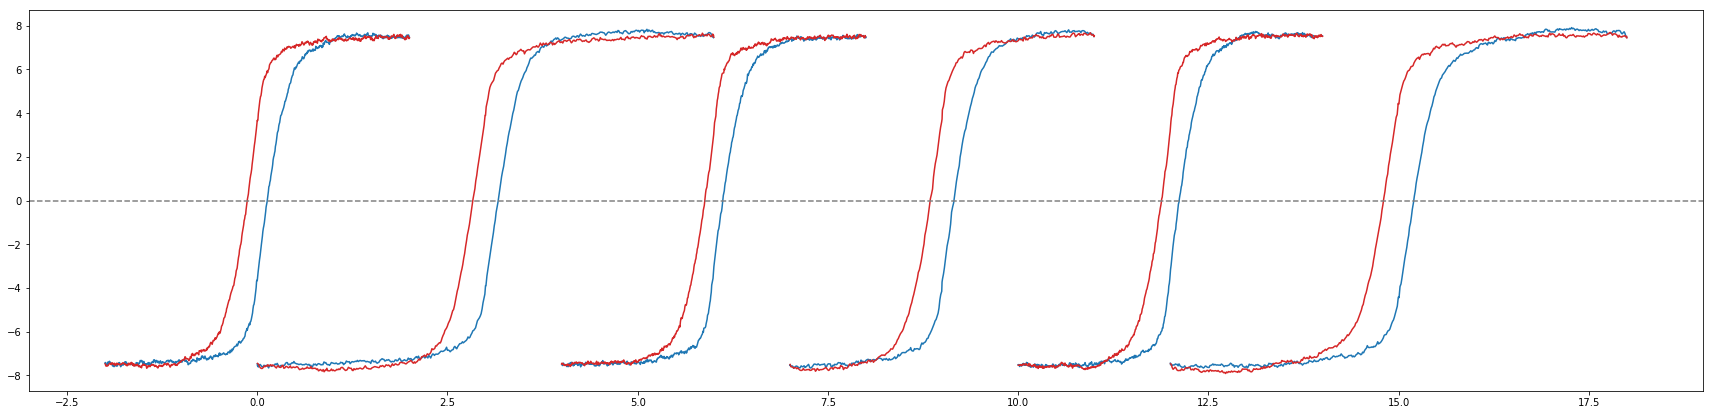

In [1474]:
all_together_now_shifted([['1454_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],
                         #['1755_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt','1812_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],
                          ['1528_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_30.1K.txt'],
                          ['1602_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],
                          #['1844_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],
                          ['1636_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_30.1K.txt'],
                          ['1918_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_30.1K.txt'],
                          ['1712_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_30.1K.txt'],
                          ['1951_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_30.1K.txt'],
#                           ['1754_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_30.1K.txt'],
#                           ['2012_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_30.1K.txt'],
#                           ['1827_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_30.1K.txt'],
#                           ['2039_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt','2052_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt'],
#                           ['1901_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG5_5.0V_30.1K.txt']
#                           ['1051_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt','1100_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt'],
                          ],
                         [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1],0,avgnumber=0)

In [1630]:
def coercivity_w_tg(filelistpos,filelistneg,slopefitpos,slopefitneg):
    pos=[(read_data_patchwork_averaging(filelistpos[i],slopefit=slopefitpos[i],sign=1,avgnumber=0))[0] for i in range(len(filelistpos))]
    neg=[(read_data_patchwork_averaging(filelistneg[i],slopefit=slopefitneg[i],sign=1,avgnumber=0))[0] for i in range(len(filelistneg))]
    fig,ax=plt.subplots()
    plt.scatter(np.array([0,-2,-4,-6,2,4]),pos)
    plt.scatter(np.array([6,0,-1,-2,-3,-5,1,3,5]),neg)
#     plt.plot(np.array([0,-2,-4,-6,2,4]),pos)
#     plt.plot(np.array([6,0,-1,-2,-3,-5,1,3,5]),neg)
    ax.set_ylabel('Coercive field [ T ]')#,color='tab:blue')
    ax.yaxis.label.set_size(18)
    ax.set_xlabel('Top gate [ V ]')
    ax.xaxis.label.set_size(18)
    plt.show

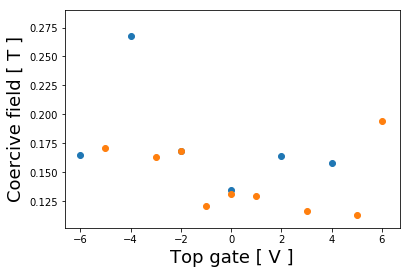

In [1631]:
coercivity_w_tg([['1755_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt','1812_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],
                 ['1844_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],
                 ['1918_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_30.1K.txt'],
                 ['1951_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_30.1K.txt'],
                 ['2012_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_30.1K.txt'],
                 ['2039_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt','2052_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt']],
                [['1051_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt','1100_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt'],
                 ['1454_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],
                 ['1528_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_30.1K.txt'],
                 ['1602_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],
                 ['1636_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_30.1K.txt'],
                 ['1712_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_30.1K.txt'],
                 ['1754_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_30.1K.txt'],
                 ['1827_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_30.1K.txt'],
                 ['1901_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG5_5.0V_30.1K.txt']],
                [-0.03,0,0.3,0.2,0.1,0.2], 
                [0.05,0.02,0.01,0.15,0.2,0.4,0.01,0.05,0]
               
               
               )

In [27]:
def sro32_plot_loop_height_and_slope(filelist1,filelist2,slopefit1,slopefit2):
    tg1=[0,-2,-4,-6,2,4]
    tg2=[6,0,-1,-2,-3,-5,1,3,5]
    loops1=slopefit1
    loops2=slopefit2
    heights1=[(read_data_patchwork_averaging(filelist1[i],slopefit=slopefit1[i],sign=1,avgnumber=0))[0][1] for i in range(len(filelist1))]
    heights2=[(read_data_patchwork_averaging(filelist2[i],slopefit=slopefit2[i],sign=1,avgnumber=0))[0][1] for i in range(len(filelist2))]
    rxx1=[0.5*(read_data_patchwork_averaging(filelist1[i],slopefit=slopefit1[i],sign=1,avgnumber=0))[1] for i in range(len(filelist1))]
    rxx2=[0.5*(read_data_patchwork_averaging(filelist2[i],slopefit=slopefit2[i],sign=1,avgnumber=0))[1] for i in range(len(filelist2))]
    
    fig, ax = plt.subplots()
    plt.scatter(tg1,rxx1)
    plt.scatter(tg2,rxx2)
    #plt.plot(tg1,rxx1)
    #plt.plot(tg2,rxx2)
    ax.set_ylabel('Sheet resistance [ Ohm ]')#,color='tab:blue')
    ax.yaxis.label.set_size(18)
    ax.set_xlabel('Top gate [ V ]')
    ax.xaxis.label.set_size(18)
    plt.show()
    
    fig, ax = plt.subplots()
    plt.scatter(tg1,heights1)
    plt.scatter(tg2,heights2)
    plt.plot(tg1,heights1)
    plt.plot(tg2,heights2)
    ax.set_ylabel('Loop height [ Ohm ]')#,color='tab:blue')
    ax.yaxis.label.set_size(18)
    ax.set_xlabel('Top gate [ V ]')
    ax.xaxis.label.set_size(18)
    plt.show()
    
    fig, ax = plt.subplots()
    plt.scatter(tg1,slopefit1)
    plt.scatter(tg2,slopefit2)
    plt.plot(tg1,slopefit1)
    plt.plot(tg2,slopefit2)
    ax.set_ylabel('OHE slope [ Ohm ]')#,color='tab:blue')
    ax.yaxis.label.set_size(18)
    ax.set_xlabel('Top gate [ V ]')
    ax.xaxis.label.set_size(18)
    plt.show()

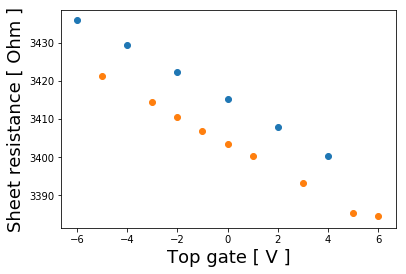

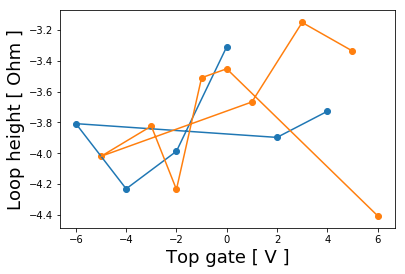

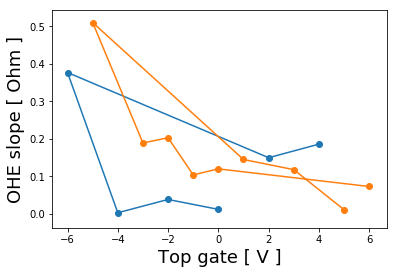

In [28]:
sro32_plot_loop_height_and_slope([['1755_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt','1812_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],
                 ['1844_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],
                 ['1918_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_30.1K.txt'],
                 ['1951_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_30.1K.txt'],
                 ['2012_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_30.1K.txt'],
                 ['2039_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt','2052_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt']],                
                [['1051_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt','1100_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt'],
                 ['1454_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],
                 ['1528_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_30.1K.txt'],
                 ['1602_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],
                 ['1636_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_30.1K.txt'],
                 ['1712_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_30.1K.txt'],
                 ['1754_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_30.1K.txt'],
                 ['1827_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_30.1K.txt'],
                 ['1901_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG5_5.0V_30.1K.txt']],
                [0.012,0.0384,0.003,0.377,0.1498,0.1859],#[-0.03,0,0.3,0.2,0.1,0.2], 
                [0.073,0.12,0.104,0.203,0.189,0.5103,0.145,0.118,0.0112])#[0.05,0.02,0.01,0.15,0.2,0.4,0.01,0.05,0])


In [176]:
read_data_patchwork_averaging(['1755_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt','1812_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],-0.03)

0.14767153677806152

In [1674]:
sro32_30_tgm2=read_data_patchwork_averaging(['1844_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],0)

In [1675]:
sro32_30_tgm4=read_data_patchwork_averaging(['1918_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_30.1K.txt'],0.3)

In [1676]:
sro32_30_tgm6=read_data_patchwork_averaging(['1951_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_30.1K.txt'],0.2)

In [1677]:
sro32_30_tg2=read_data_patchwork_averaging(['2012_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_30.1K.txt'],0.1)

In [1678]:
sro32_30_tg4=read_data_patchwork_averaging(['2039_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt','2052_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt'],0.1)

In [1679]:
sro32_30_tg6=read_data_patchwork_averaging(['1051_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt','1100_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt'],0.05)

In [1680]:
sro32_30_tg0_b1=read_data_patchwork_averaging(['1454_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],0.02)

In [1681]:
sro32_30_tgm1=read_data_patchwork_averaging(['1528_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_30.1K.txt'],0.01)

In [1682]:
sro32_30_tgm2_b1=read_data_patchwork_averaging(['1602_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],0.15)

In [1683]:
sro32_30_tgm3=read_data_patchwork_averaging(['1636_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_30.1K.txt'],0.2)

In [1684]:
sro32_30_tgm5=read_data_patchwork_averaging(['1712_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_30.1K.txt'],0.4)

In [1685]:
sro32_30_tg1=read_data_patchwork_averaging(['1754_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_30.1K.txt'],0.01)

In [1686]:
sro32_30_tg3=read_data_patchwork_averaging(['1827_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_30.1K.txt'],0.05)

In [1687]:
sro32_30_tgm4=read_data_patchwork_averaging(['1901_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG5_5.0V_30.1K.txt'],-0.01)

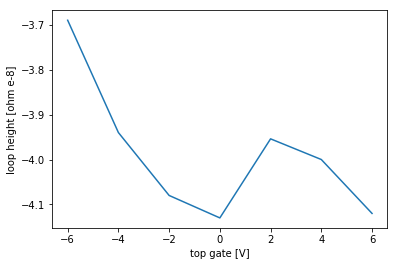

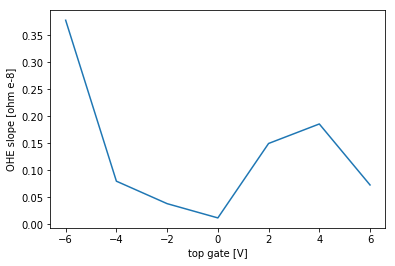

In [596]:
import matplotlib.pyplot as plt
def plot_loop_height_and_Hall_slope():
    xaxis=[-6,-4,-2,0,2,4,6]
    loop_height=[-3.69,-3.94,-4.08,-4.13,-3.954,-4,-4.12]
    hall_slope=[0.3779,0.08,0.0384,0.012,0.1498,0.1859,0.073]
    fig, ax = plt.subplots()
    ax.plot(xaxis,loop_height)
    plt.xlabel("top gate [V]")
    plt.ylabel("loop height [ohm e-8]")
    plt.show()
    fig, ax = plt.subplots()
    ax.plot(xaxis,hall_slope)
    plt.xlabel("top gate [V]")
    plt.ylabel("OHE slope [ohm e-8]")
    plt.show()
plot_loop_height_and_Hall_slope()

In [ ]:
import matplotlib.pyplot as plt
def plot_loop_height_and_Hall_slope():
    xaxis1=[0,-1,-2,-3,-3.5,-4,-4,-4,-5,-6,-7,-8,-3.25,-3.75,-4,-3,-3.25,-3.75,-4,-3,-3.25,-3.5,-3.75,0,-1,-2,-3,-4,-4,-5,-6,-7,5,6,7,8,-8,-6,-8,6]
    loop_height1=[-6.681,-7.574,-7.327,-7.389,-7.134,-7.236,-7.382]
    hall_slope1=[0.377,0.003,0.0384,0.012,0.1498,0.1859,0.073]
    xaxis2=[-5,-3,-2,-1,0,1,3,5]
    loop_height2=[-6.794,-7.1772,-7.097,-7.329,-7.224,-7.217,-7.2914,-7.519]
    hall_slope2=[0.5103,0.189,0.203,0.104,0.12,0.145,0.118,0.0112]
    fig, ax = plt.subplots()
    plt.scatter(xaxis1,loop_height1)
    plt.scatter(xaxis2,loop_height2)
    ax.plot(xaxis1,loop_height1)
    ax.plot(xaxis2,loop_height2)
    plt.xlabel("top gate [V]")
    plt.ylabel("loop height [ohm e-8]")
    plt.show()
    fig, ax = plt.subplots()
    plt.scatter(xaxis1,hall_slope1)
    plt.scatter(xaxis2,hall_slope2)
    ax.plot(xaxis1,hall_slope1)
    ax.plot(xaxis2,hall_slope2)
    plt.xlabel("top gate [V]")
    plt.ylabel("OHE slope [ohm e-8]")
    plt.show()
plot_loop_height_and_Hall_slope()

In [190]:
def read_data_patchwork_averaging(filename,slopefit,avgnumber=3,sign=1,ohe_antisym_prec=20,ohe_sym_prec=20):
    '''
    filename should be of the format ['filename.txt',etc]
    '''
    
    def pre_shave(datafile):
        B=[float(i) for i in datafile.B[2:]]
        I=[float(i) for i in datafile.I_gate[2:]]
        Rxx=[float(i) for i in datafile.R_xx[2:]]
        Rxy=[sign*float(i) for i in datafile.R_xy[2:]]
        Thetaxy=[float(i) for i in datafile.Theta_xy[2:]]
        Thetaxx=[float(i) for i in datafile.Theta_xx[2:]]
        Thetaxy=[np.cos(np.deg2rad(i)) for i in Thetaxy]
        Thetaxx=[np.cos(np.deg2rad(i)) for i in Thetaxx]
        Rxy=[Rxy[i]*Thetaxy[i] for i in range(len(Rxy))] #muliplying by the phase
        Rxx=[Rxx[i]*Thetaxx[i] for i in range(len(Rxx))]
        return B,Rxx,Rxy,I
    
    def averaging(datafile):
        B,Rxx,Rxy,I=pre_shave(datafile=datafile)
        rxy_begin=[sum(Rxy[i:i+avgnumber])/(avgnumber)  for i in range(0,avgnumber) ]
        rxx_begin=[sum(Rxx[i:i+avgnumber])/(avgnumber)  for i in range(0,avgnumber) ]
        rxy_mid=[sum(Rxy[i-avgnumber:i+avgnumber])/(2*avgnumber)  for i in range(avgnumber,len(Rxy)-avgnumber)  ]
        rxx_mid=[sum(Rxx[i-avgnumber:i+avgnumber])/(2*avgnumber)  for i in range(avgnumber,len(Rxx)-avgnumber)  ]
        rxy_end=[sum(Rxy[i-avgnumber:i])/(avgnumber)  for i in [-avgnumber-1+j for j in range(avgnumber)] ]
        rxx_end=[sum(Rxx[i-avgnumber:i])/(avgnumber)  for i in [-avgnumber-1+j for j in range(avgnumber)] ]
        rxy=rxy_begin+rxy_mid+rxy_end
        rxx=rxx_begin+rxx_mid+rxx_end
        return B,rxx,rxy,I
    
    filesn=len(filename)
    if filesn==1:
        data=pd.read_csv(filename[0],sep='\t')
        data.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        if avgnumber==0:
            B,Rxx,Rxy,I=pre_shave(data)
        else:
            B,Rxx,Rxy,I=averaging(data)
    elif filesn==2:
        data1=pd.read_csv(filename[0],sep='\t')
        data1.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        data2=pd.read_csv(filename[1],sep='\t')
        data2.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        if avgnumber==0:
            B1,Rxx1,Rxy1,I1=pre_shave(data1)
            B2,Rxx2,Rxy2,I2=pre_shave(data2)
        else:
            B1,Rxx1,Rxy1,I1=averaging(data1)
            B2,Rxx2,Rxy2,I2=averaging(data2)
        I=I1+I2
        B=B1+B2
        Rxx=Rxx1+Rxx2
        Rxy=Rxy1+Rxy2
    elif filesn==3:
        data1=pd.read_csv(filename[0],sep='\t')
        data1.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        data2=pd.read_csv(filename[1],sep='\t')[2:]
        data2.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        data3=pd.read_csv(filename[2],sep='\t')[16:]
        data3.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        if avgnumber==0:
            B1,Rxx1,Rxy1,I1=pre_shave(data1)
            B2,Rxx2,Rxy2,I2=pre_shave(data2)
            B3,Rxx3,Rxy3,I3=pre_shave(data3)
        else:
            B1,Rxx1,Rxy1,I1=averaging(data1)
            B2,Rxx2,Rxy2,I2=averaging(data2)
            B3,Rxx3,Rxy3,I3=averaging(data3)
        
        I=I1+I2+I3
        B=B1+B2+B3
        Rxx=Rxx1+Rxx2+Rxx3
        Rxy=Rxy1+Rxy2+Rxy3
    
    
    
    def shave():
        npl=np.array(B)
        #getting rid of zeroes
        #[npz]=np.where(npl==0)
        #getting rid of repeating points at the opposite ends of the sweep
        [nplmax]=np.where(npl==np.max(npl))
        if len(nplmax)!=0:
            indmid1=len(nplmax)//2 #the middle one, because why not
            indrep=np.delete(nplmax,indmid1)#list of indices where we're stuck at repeating 7
        else:
            indrep=[0]
        [nplmin]=np.where(npl==np.min(npl))
        if len(nplmin)!=0:
            indmid2=len(nplmin)//2 #the middle one, because why not
            indrepm=np.delete(nplmin,indmid2)#list of indices where we're stuck at repeating 7
        else:
            indrepm=[0]
        #let's make a superlist of all the indices we want to rid lB of
        indtodel=indrep#np.append(npz,indrep)
        indtodel=np.append(indtodel,indrepm)
        proc_B=np.delete(B,indtodel)
        proc_I=np.delete(I,indtodel)
        proc_Rxx=np.delete(Rxx,indtodel)
        proc_Rxy=np.delete(Rxy,indtodel)
        return proc_B,proc_Rxx,proc_Rxy,proc_I
    
    proc_B,proc_Rxx,proc_Rxy,proc_I=shave()
    
    def plot_B(x):
        fig, ax = plt.subplots()
        xaxis=range(len(x))
        ax.plot(xaxis,x)
        plt.yticks([])
        plt.show()
    def plot_res(x):
        fig, ax = plt.subplots()
        xaxis=proc_B
        ax.plot(xaxis,x)
        plt.yticks()
        plt.show()
        
        
    #plot_B(proc_B)
    #plot_res(proc_Rxx)
    #plot_res(proc_Rxy)
    
    
    def antisymmetrize(mat,proc_B=proc_B):
        [hi_point]=np.where(proc_B==np.max(proc_B))[0]
        [lo_point]=np.where(proc_B==np.min(proc_B))[0]
        [mid_point]=np.where(proc_B==0)
        mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        #print(mid)
        if len(mid)>4:
            #hopefully shit is only occuring at the end
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
    
        if len(mid)<3:
            ensure_init_0=np.array([0])
            proc_B_t=np.append(ensure_init_0,proc_B)
            proc_B=proc_B_t
            [hi_point]=np.where(proc_B==np.max(proc_B))[0]
            [lo_point]=np.where(proc_B==np.min(proc_B))[0]
            [mid_point]=np.where(proc_B==0)
            mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)==3: #only one 0 value in the middle: affects he down sweep
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            smol_hi_zero=mid[2]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[smol_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[smol_mid_zero:lo_point]
        if len(mid)==4: #only the down sweep is affected
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        
            
        ##valid if we start w positive first!
        ub1=proc_B[lo_point:smol_hi_zero]
        ub2=proc_B[big_lo_zero:hi_point]
        u1=mat[lo_point:smol_hi_zero]
        u2=mat[big_lo_zero:hi_point]
        
        #we should interpolate chunk-by-chunk
        
        ub=np.append(ub1,ub2)
        db=np.append(db1,db2)
        
        if len(ub)>len(db):
            d1=np.flip(np.interp(ub2,np.flip(db1,0),np.flip(d1,0)),0)
            d2=np.flip(np.interp(ub1,np.flip(db2,0),np.flip(d2,0)),0)
            u=np.append(u1,u2)
            d=np.append(d1,d2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('db smoler')
            return ub,g
        if len(ub)<len(db):
            u1=np.interp(np.flip(db2,0),ub1,u1)
            u2=np.interp(np.flip(db1,0),ub2,u2)
            u=np.append(u1,u2)
            d=np.append(d1,d2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('ub smoler')
            return np.flip(db,0),g
        if len(ub)==len(db):
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('same')
            return ub,g#ub,u,db,d,len(ub)-len(db)
    
    def symmetrize(mat,proc_B=proc_B):
        [hi_point]=np.where(proc_B==np.max(proc_B))[0]
        [lo_point]=np.where(proc_B==np.min(proc_B))[0]
        [mid_point]=np.where(proc_B==0)
        mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        
        if len(mid)>4:
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        if len(mid)<3:
            ensure_init_0=np.array([0])
            proc_B_t=np.append(ensure_init_0,proc_B)
            proc_B=proc_B_t
            [hi_point]=np.where(proc_B==np.max(proc_B))[0]
            [lo_point]=np.where(proc_B==np.min(proc_B))[0]
            [mid_point]=np.where(proc_B==0)
            mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)==3: #only one 0 value in the middle: affects he down sweep
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            smol_hi_zero=mid[2]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[smol_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[smol_mid_zero:lo_point]
        if len(mid)==4: #only the down sweep is affected
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        ##valid if we start w positive first!
        ub1=proc_B[lo_point:smol_hi_zero]
        ub2=proc_B[big_lo_zero:hi_point]
        u1=mat[lo_point:smol_hi_zero]
        u2=mat[big_lo_zero:hi_point]
        
        #we should interpolate chunk-by-chunk
        
        ub=np.append(ub1,ub2)
        db=np.append(db1,db2)
        
        if len(ub)>len(db):
            d1=np.flip(np.interp(ub2,np.flip(db1,0),np.flip(d1,0)),0)
            d2=np.flip(np.interp(ub1,np.flip(db2,0),np.flip(d2,0)),0)
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            d=np.flip(d,0)
            g=np.add(u,d)/2
            #print('ub bigger')
            return ub,g
        if len(ub)<len(db):
            u1=np.interp(np.flip(db2,0),ub1,u1)
            u2=np.interp(np.flip(db1,0),ub2,u2)
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            d=np.flip(d,0)
            g=np.add(u,d)/2
            #print('db bigger')
            return np.flip(db,0),g
        if len(ub)==len(db):
            d=np.append(d1,d2)
            d=np.flip(d,0)
            u=np.append(u1,u2)
            g=np.add(u,d)/2
            #print('same')
            return ub,g#ub,u,db,d,len(ub)-len(db)
        
    
    def plot_antisym(mat):
        fig, ax = plt.subplots()
        xaxis,x=antisymmetrize(mat)
        ax.plot(xaxis,x)
        ax.plot(np.flip(xaxis,0),-x)
        plt.show()
    
    
    
    def remove_OHE_antisym(mat,yall):
        rawx,rawy=antisymmetrize(mat)
        #[a1,b1]=np.polyfit(rawx[0:yall],rawy[0:yall],1)
        a1=slopefit
        subtract_vector=np.array([a1*i for i in rawx])
        no_ohe=np.subtract(rawy,subtract_vector)
        #print(a1)
        return rawx,no_ohe,a1
    
    def remove_OHE_sym(mat):
        rawx,rawy=symmetrize(mat)
        [a,b]=np.polyfit(rawx[-ohe_sym_prec:-1],rawy[-ohe_sym_prec:-1],1)
        subtract_vector=np.array([a*i for i in rawx])
        no_ohe=np.subtract(rawy,subtract_vector)
        return rawx,no_ohe
    
    def plot_sym_rem(mat):
        fig, ax = plt.subplots()
        xaxis,x=remove_OHE_sym(mat)
        ax.plot(xaxis,x)
        ax.plot(-xaxis,x)
        plt.show()
    def plot_sym(mat):
        fig, ax = plt.subplots()
        xaxis,x=symmetrize(mat)
        ax.plot(xaxis,x)
        ax.plot(-xaxis,x)
        plt.show()
        
    #plot_sym(proc_Rxy)
    #plot_sym_rem(proc_Rxy)
    
    
    def conductance():
        if ohe_antisym_prec==0:
            gena,genb,a1=remove_OHE_antisym(proc_Rxy,100)
            xyub,rxy_vec=antisymmetrize(proc_Rxy)
            xxub,rxx_vec=symmetrize(proc_Rxx)
            conductance_vec=np.array([rxy_vec[i]/(rxx_vec[i])**2 for i in range(len(rxy_vec))])
            lh=sum(conductance_vec[0:20])/20
            #print('loop height:',lh  )
            o200=np.array([int(i) for i in range(1,50)])
            arrau=abs(lh-(conductance_vec[0]))/abs(lh-(conductance_vec[o200]))
            bb=np.where((0.99<arrau) & (arrau<1.001))
            #print(conductance_vec[bb],bb)
            atz=np.where(np.array(xyub)==0)
            #print('hatz',conductance_vec[atz])
            
        else:
            xyub,rxy_vec,a1=remove_OHE_antisym(proc_Rxy,ohe_antisym_prec)
            xxub,rxx_vec=symmetrize(proc_Rxx)
            conductance_vec=np.array([rxy_vec[i]/(rxx_vec[i])**2 for i in range(len(rxy_vec))])
            lh=sum(conductance_vec[0:ohe_antisym_prec])/ohe_antisym_prec
            #print('loop height:',lh  )
            o200=np.array([int(i) for i in range(1,50)])
            arrau=abs(lh-(conductance_vec[0]))/abs(lh-(conductance_vec[o200]))
            bb=np.where((0.99<arrau) & (arrau<1.001))
            #print(conductance_vec[bb],bb)
            [atz]=np.where(np.array(xyub)==0)
            #print('hatz',conductance_vec[atz])
            [satz]=np.where((conductance_vec<0.000000001) & (conductance_vec>-0.000000001))
        
        def plot_():
            fig, ax = plt.subplots()
            xaxis=xyub
            x=np.array(rxy_vec)
            ax.plot(xaxis,x)
            ax.plot(np.flip(xaxis,0),-x)
            plt.show()
        #plot_()
        #return xyub,rxy_vec 
        #return a1,rxy_vec[atz]
        return sum(xyub[satz])/len(satz)
    
    return conductance()#,0.5*(proc_Rxx[0]+proc_Rxx[-1])/2#antisymmetrize(proc_Rxy)

In [18]:
def all_together_now_shifted(filelist,slopefit,signs,avgnumber):
    h=[(read_data_patchwork_averaging(filelist[i],slopefit=slopefit[i],sign=signs[i],avgnumber=avgnumber)) for i in range(len(filelist))]
    fig,ax=plt.subplots(figsize=(30,7))
    for i in range(len(h)):
        ax.plot(h[i][0]+12*i,h[i][1],color='tab:blue')
        ax.plot(-h[i][0]+12*i,-h[i][1],color='tab:red')
    plt.axhline(0,linestyle='--',color='gray')
    plt.savefig('5_loops.eps', format='eps',bbox_inches='tight')
    plt.show()

In [19]:
all_together_now_shifted([['1211_SR032_MR_Hall_I6-3_V5-4_VHall7-5_loopcheck_0.0V_9.9K.txt'],
                          ['1027_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_9.9K.txt'],
                          ['1115_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_9.9K.txt']],
                        [0,-0.05,-0.07],0)

TypeError: all_together_now_shifted() missing 1 required positional argument: 'avgnumber'

In [2034]:
sro32_10_tg0=read_data_patchwork_averaging(['1211_SR032_MR_Hall_I6-3_V5-4_VHall7-5_loopcheck_0.0V_9.9K.txt'],0)

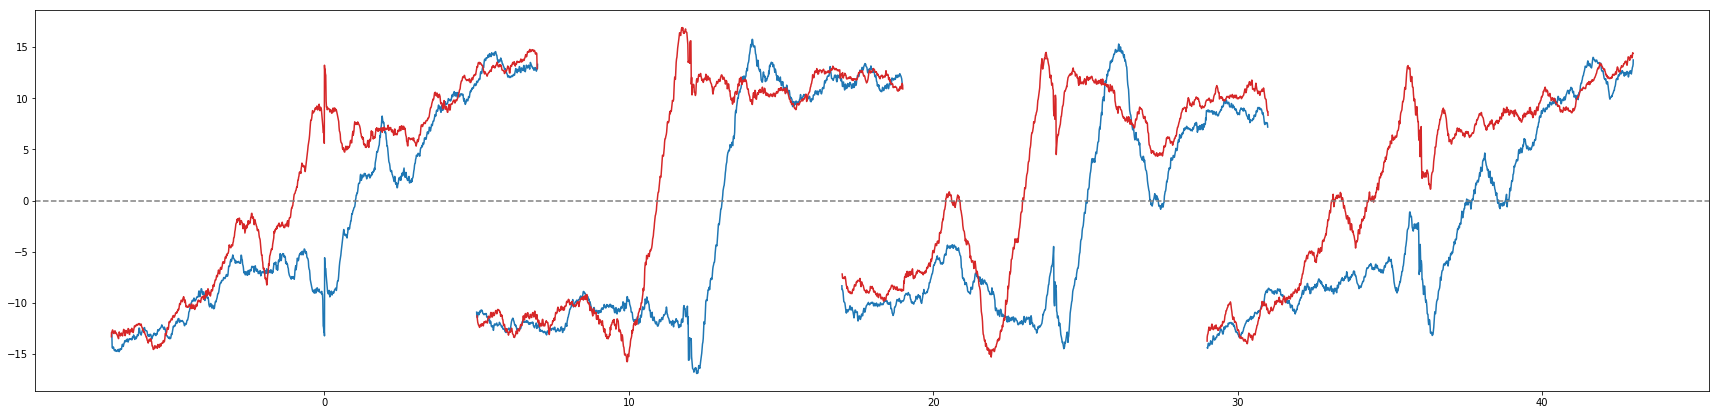

In [2089]:
all_together_now_shifted([['1414_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_4.9K.txt'],
                          ['1520_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_4.9K.txt'],
                          ['1627_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_4.9K.txt'],
                          ['1731_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_4.9K.txt']
                         ],
                        [-1,-0.6,-0.05,-1],
                         #[0,0,0,0],
                         [1,1,10,1]
                         ,8)

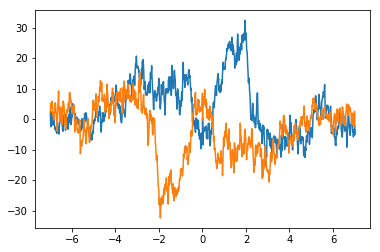

In [22]:
sro32_5_tg0=read_data_patchwork_averaging(['1414_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_4.9K.txt'],0.07)

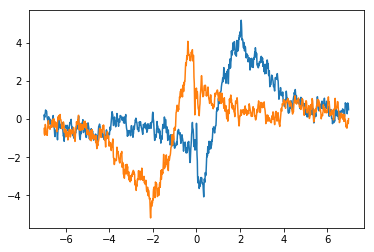

In [23]:
sro32_5_tg0_b1=read_data_patchwork_averaging(['1520_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_4.9K.txt'],0)

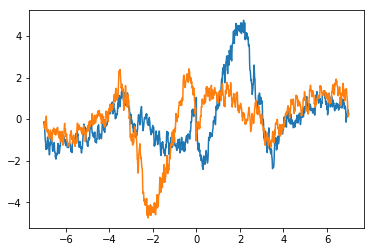

In [24]:
sro32_5_tgm4=read_data_patchwork_averaging(['1627_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_4.9K.txt'],0)

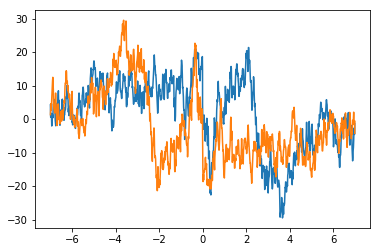

In [25]:
sro32_5_tgm3=read_data_patchwork_averaging(['1731_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_4.9K.txt'],0)

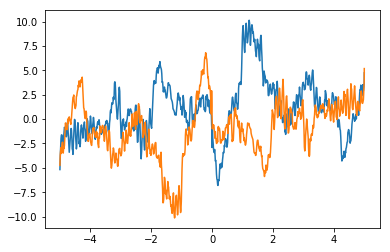

In [26]:
sro32_10_tg0=read_data_patchwork_averaging(['1027_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_9.9K.txt'],-0.05)

In [2040]:
sro32_10_tgm6=read_data_patchwork_averaging(['1115_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_9.9K.txt'],-0.07,0)

In [1956]:
def all_together_now_shifted(filelist,slopefit,avgnumber):
    h=[(read_data_patchwork_averaging(filelist[i],slopefit=slopefit[i],avgnumber=avgnumber)) for i in range(len(filelist))]
    fig,ax=plt.subplots(figsize=(30,7))
    for i in range(len(h)):
        ax.plot(h[i][0][0]+5*i,h[i][0][1],color='tab:blue')
        ax.plot(-h[i][0][0]+5*i,-h[i][0][1],color='tab:red')
    plt.axhline(0,linestyle='--',color='gray')
    plt.savefig('15_loops.eps', format='eps',bbox_inches='tight')
    plt.show()

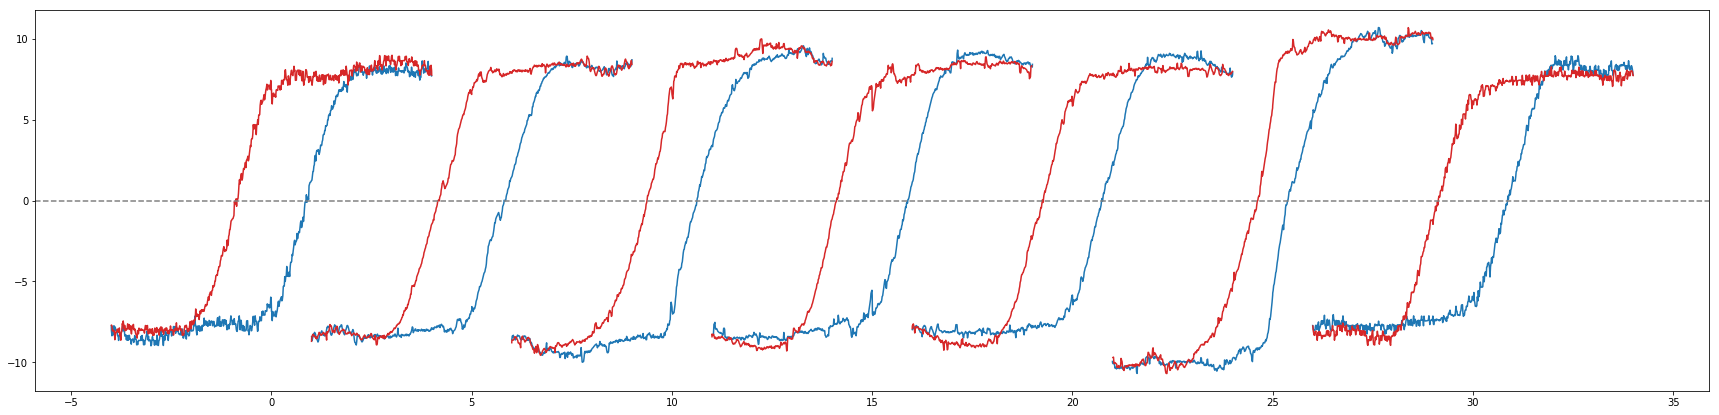

In [1967]:
all_together_now_shifted([
                          ['1332_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_15.1K.txt'],
                          ['1405_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_15.0K.txt'],
                          ['1441_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_15.1K.txt'],
                          ['1515_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_15.0K.txt'],
                          ['1625_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_15.1K.txt'],
                          ['1658_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_15.0K.txt'],
                          ['1256_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_15.1K.txt'],
                         ],
                        [0,-0.2,-0.2,-0.3,-0.1,-0.5,0],0)

In [1969]:
def coercivity_w_tg(filelist,slopefit):
    pos=[(read_data_patchwork_averaging(filelist[i],slopefit=slopefit[i],sign=1,avgnumber=0))[0] for i in range(len(filelist))]
    fig,ax=plt.subplots()
    plt.scatter(np.array([-6,-5,-4,-3,-2,-1,0]),pos)
    plt.plot(np.array([-6,-5,-4,-3,-2,-1,0]),pos)
    ax.set_ylabel('Coercive field [ T ]')#,color='tab:blue')
    ax.yaxis.label.set_size(18)
    ax.set_xlabel('Top gate [ V ]')
    ax.xaxis.label.set_size(18)
    plt.show

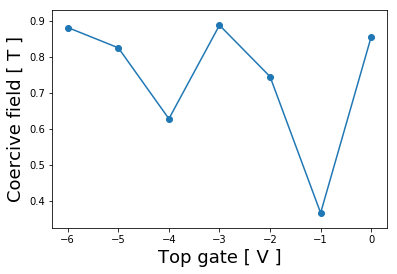

In [1973]:
coercivity_w_tg([['1332_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_15.1K.txt'],
                          ['1405_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_15.0K.txt'],
                          ['1441_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_15.1K.txt'],
                          ['1515_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_15.0K.txt'],
                          ['1625_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_15.1K.txt'],
                          ['1658_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_15.0K.txt'],
                          ['1256_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_15.1K.txt']
                         ],
                        [0,-0.2,-0.2,-0.3,-0.1,-0.5,0])

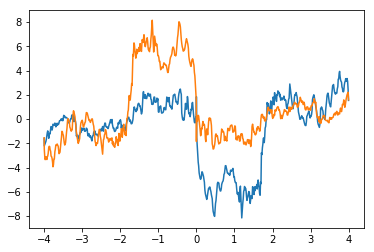

In [27]:
sro32_15_tg0=read_data_patchwork_averaging(['1256_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_15.1K.txt'],0)

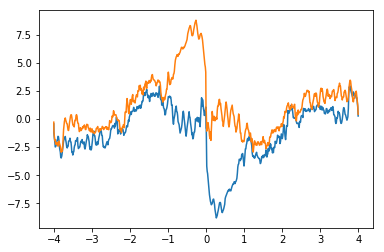

In [28]:
sro32_15_tgm6=read_data_patchwork_averaging(['1332_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_15.1K.txt'],0)

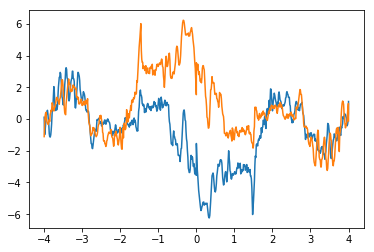

In [29]:
sro32_15_tgm5=read_data_patchwork_averaging(['1405_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_15.0K.txt'],-0.2)

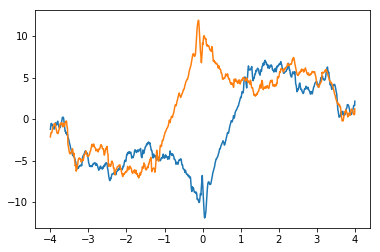

In [30]:
sro32_15_tgm4=read_data_patchwork_averaging(['1441_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_15.1K.txt'],-0.2)

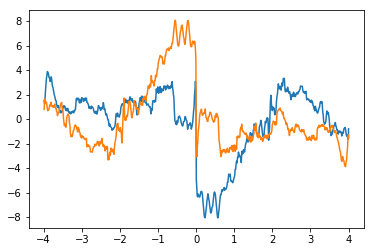

In [31]:
sro32_15_tgm3=read_data_patchwork_averaging(['1515_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_15.0K.txt'],-0.3)

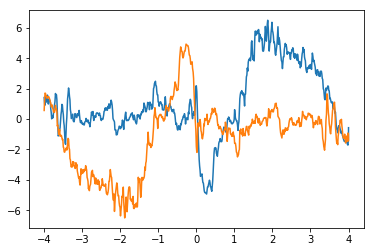

In [32]:
sro32_15_tgm2=sro32_15_tgm2=read_data_patchwork_averaging(['1625_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_15.1K.txt'],-0.1)

In [1761]:
def read_data_patchwork_averaging_cherrypickmid(filename,slopefit,avgnumber=3,sign=1,ohe_antisym_prec=20,ohe_sym_prec=20):
    '''
    filename should be of the format ['filename.txt',etc]
    '''
    
    def pre_shave(datafile):
        B=[float(i) for i in datafile.B[2:]]
        I=[float(i) for i in datafile.I_gate[2:]]
        Rxx=[float(i) for i in datafile.R_xx[2:]]
        Rxy=[sign*float(i) for i in datafile.R_xy[2:]]
        Thetaxy=[float(i) for i in datafile.Theta_xy[2:]]
        Thetaxx=[float(i) for i in datafile.Theta_xx[2:]]
        Thetaxy=[np.cos(np.deg2rad(i)) for i in Thetaxy]
        Thetaxx=[np.cos(np.deg2rad(i)) for i in Thetaxx]
        Rxy=[Rxy[i]*Thetaxy[i] for i in range(len(Rxy))] #muliplying by the phase
        Rxx=[Rxx[i]*Thetaxx[i] for i in range(len(Rxx))]
        return B,Rxx,Rxy,I
    
    def averaging(datafile):
        B,Rxx,Rxy,I=pre_shave(datafile=datafile)
        rxy_begin=[sum(Rxy[i:i+avgnumber])/(avgnumber)  for i in range(0,avgnumber) ]
        rxx_begin=[sum(Rxx[i:i+avgnumber])/(avgnumber)  for i in range(0,avgnumber) ]
        rxy_mid=[sum(Rxy[i-avgnumber:i+avgnumber])/(2*avgnumber)  for i in range(avgnumber,len(Rxy)-avgnumber)  ]
        rxx_mid=[sum(Rxx[i-avgnumber:i+avgnumber])/(2*avgnumber)  for i in range(avgnumber,len(Rxx)-avgnumber)  ]
        rxy_end=[sum(Rxy[i-avgnumber:i])/(avgnumber)  for i in [-avgnumber-1+j for j in range(avgnumber)] ]
        rxx_end=[sum(Rxx[i-avgnumber:i])/(avgnumber)  for i in [-avgnumber-1+j for j in range(avgnumber)] ]
        rxy=rxy_begin+rxy_mid+rxy_end
        rxx=rxx_begin+rxx_mid+rxx_end
        return B,rxx,rxy,I
    
    filesn=len(filename)
    if filesn==1:
        data=pd.read_csv(filename[0],sep='\t')
        data.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        if avgnumber==0:
            B,Rxx,Rxy,I=pre_shave(data)
        else:
            B,Rxx,Rxy,I=averaging(data)
    elif filesn==2:
        data1=pd.read_csv(filename[0],sep='\t')
        data1.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        data2=pd.read_csv(filename[1],sep='\t')
        data2.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        if avgnumber==0:
            B1,Rxx1,Rxy1,I1=pre_shave(data1)
            B2,Rxx2,Rxy2,I2=pre_shave(data2)
        else:
            B1,Rxx1,Rxy1,I1=averaging(data1)
            B2,Rxx2,Rxy2,I2=averaging(data2)
        I=I1+I2
        B=B1+B2
        Rxx=Rxx1+Rxx2
        Rxy=Rxy1+Rxy2
    elif filesn==3:
        data1=pd.read_csv(filename[0],sep='\t')
        data1.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        data2=pd.read_csv(filename[1],sep='\t')[2:]
        data2.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        data3=pd.read_csv(filename[2],sep='\t')[2:]
        data3.columns = ["time", "B", "R_xx","Theta_xx","R_xy","Theta_xy","I_gate","nan"]
        if avgnumber==0:
            B1,Rxx1,Rxy1,I1=pre_shave(data1)
            B2,Rxx2,Rxy2,I2=pre_shave(data2)
            B3,Rxx3,Rxy3,I3=pre_shave(data3)
        else:
            B1,Rxx1,Rxy1,I1=averaging(data1)
            B2,Rxx2,Rxy2,I2=averaging(data2)
            B3,Rxx3,Rxy3,I3=averaging(data3)
        
        I=I1+I2+I3
        B=B1+B2+B3
        Rxx=Rxx1+Rxx2+Rxx3
        Rxy=Rxy1+Rxy2+Rxy3
    
    def shave():
        npl=np.array(B)
        #getting rid of zeroes
        #[npz]=np.where(npl==0)
        #getting rid of repeating points at the opposite ends of the sweep
        [nplmax]=np.where(npl==np.max(npl))
        if len(nplmax)!=0:
            indmid1=len(nplmax)//2 #the middle one, because why not
            indrep=np.delete(nplmax,indmid1)#list of indices where we're stuck at repeating 7
        else:
            indrep=[0]
        [nplmin]=np.where(npl==np.min(npl))
        if len(nplmin)!=0:
            indmid2=len(nplmin)//2 #the middle one, because why not
            indrepm=np.delete(nplmin,indmid2)#list of indices where we're stuck at repeating 7
        else:
            indrepm=[0]
        #let's make a superlist of all the indices we want to rid lB of
        indtodel=indrep#np.append(npz,indrep)
        indtodel=np.append(indtodel,indrepm)
        proc_B=np.delete(B,indtodel)
        proc_Rxx=np.delete(Rxx,indtodel)
        proc_Rxy=np.delete(Rxy,indtodel)
        proc_I=np.delete(I,indtodel)
        return proc_B,proc_Rxx,proc_Rxy,proc_I
    
    proc_B,proc_Rxx,proc_Rxy,proc_I=shave()
    
    def plot_B(x):
        fig, ax = plt.subplots()
        xaxis=range(len(x))
        ax.plot(xaxis,x)
        plt.yticks([])
        plt.show()
    def plot_res(x):
        fig, ax = plt.subplots()
        xaxis=proc_B
        ax.plot(xaxis,x)
        plt.yticks()
        plt.show()
        
        
    #plot_B(proc_B)
    #plot_res(proc_Rxx)
    plot_res(proc_Rxy)
    
    
    def antisymmetrize(mat,proc_B=proc_B):
        [hi_point]=np.where(proc_B==np.max(proc_B))[0]
        [lo_point]=np.where(proc_B==np.min(proc_B))[0]
        [mid_point]=np.where(proc_B==0)
        mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        print(mid)
        
    
        if len(mid)<3:
            ensure_init_0=np.array([0])
            proc_B_t=np.append(ensure_init_0,proc_B)
            proc_B=proc_B_t
            [hi_point]=np.where(proc_B==np.max(proc_B))[0]
            [lo_point]=np.where(proc_B==np.min(proc_B))[0]
            [mid_point]=np.where(proc_B==0)
            mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)==3: #only one 0 value in the middle: affects he down sweep
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            smol_hi_zero=mid[2]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[smol_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[smol_mid_zero:lo_point]
        if len(mid)==4: #only the down sweep is affected
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        if len(mid)>4:
            #hopefully shit is only occuring at the end
            big_lo_zero=mid[2]
            smol_mid_zero=mid[3]
            big_mid_zero=mid[4]
            smol_hi_zero=mid[5]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        
            
        ##valid if we start w positive first!
        ub1=proc_B[lo_point:smol_hi_zero]
        ub2=proc_B[big_lo_zero:hi_point]
        u1=mat[lo_point:smol_hi_zero]
        u2=mat[big_lo_zero:hi_point]
        
        #we should interpolate chunk-by-chunk
        
        ub=np.append(ub1,ub2)
        db=np.append(db1,db2)
        
        if len(ub)>len(db):
            d1=np.flip(np.interp(ub2,np.flip(db1,0),np.flip(d1,0)),0)
            d2=np.flip(np.interp(ub1,np.flip(db2,0),np.flip(d2,0)),0)
            u=np.append(u1,u2)
            d=np.append(d1,d2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('db smoler')
            return ub,g
        if len(ub)<len(db):
            u1=np.interp(np.flip(db2,0),ub1,u1)
            u2=np.interp(np.flip(db1,0),ub2,u2)
            u=np.append(u1,u2)
            d=np.append(d1,d2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('ub smoler')
            return np.flip(db,0),g
        if len(ub)==len(db):
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            #d=np.flip(d,0)
            g=np.subtract(u,d)/2
            #print('same')
            return ub,g#ub,u,db,d,len(ub)-len(db)
    
    def symmetrize(mat,proc_B=proc_B):
        [hi_point]=np.where(proc_B==np.max(proc_B))[0]
        [lo_point]=np.where(proc_B==np.min(proc_B))[0]
        [mid_point]=np.where(proc_B==0)
        mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        
        if len(mid)>4:
            big_lo_zero=mid[2]
            smol_mid_zero=mid[3]
            big_mid_zero=mid[4]
            smol_hi_zero=mid[5]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        if len(mid)<3:
            ensure_init_0=np.array([0])
            proc_B_t=np.append(ensure_init_0,proc_B)
            proc_B=proc_B_t
            [hi_point]=np.where(proc_B==np.max(proc_B))[0]
            [lo_point]=np.where(proc_B==np.min(proc_B))[0]
            [mid_point]=np.where(proc_B==0)
            mid=[mid_point[i] for i in range(len(mid_point)-1) if mid_point[i+1]-mid_point[i]>1 or mid_point[i]-mid_point[i-1]>1 ] #indices of our four zero points
        if len(mid)==3: #only one 0 value in the middle: affects he down sweep
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            smol_hi_zero=mid[2]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[smol_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[smol_mid_zero:lo_point]
        if len(mid)==4: #only the down sweep is affected
            big_lo_zero=mid[0]
            smol_mid_zero=mid[1]
            big_mid_zero=mid[2]
            smol_hi_zero=mid[3]
            db1=proc_B[hi_point:smol_mid_zero]
            db2=proc_B[big_mid_zero:lo_point]
            d1=mat[hi_point:smol_mid_zero]
            d2=mat[big_mid_zero:lo_point]
        ##valid if we start w positive first!
        ub1=proc_B[lo_point:smol_hi_zero]
        ub2=proc_B[big_lo_zero:hi_point]
        u1=mat[lo_point:smol_hi_zero]
        u2=mat[big_lo_zero:hi_point]
        
        #we should interpolate chunk-by-chunk
        
        ub=np.append(ub1,ub2)
        db=np.append(db1,db2)
        
        if len(ub)>len(db):
            d1=np.flip(np.interp(ub2,np.flip(db1,0),np.flip(d1,0)),0)
            d2=np.flip(np.interp(ub1,np.flip(db2,0),np.flip(d2,0)),0)
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            d=np.flip(d,0)
            g=np.add(u,d)/2
            #print('ub bigger')
            return ub,g
        if len(ub)<len(db):
            u1=np.interp(np.flip(db2,0),ub1,u1)
            u2=np.interp(np.flip(db1,0),ub2,u2)
            d=np.append(d1,d2)
            u=np.append(u1,u2)
            d=np.flip(d,0)
            g=np.add(u,d)/2
            #print('db bigger')
            return np.flip(db,0),g
        if len(ub)==len(db):
            d=np.append(d1,d2)
            d=np.flip(d,0)
            u=np.append(u1,u2)
            g=np.add(u,d)/2
            #print('same')
            return ub,g#ub,u,db,d,len(ub)-len(db)
        
    
    def plot_antisym(mat):
        fig, ax = plt.subplots()
        xaxis,x=antisymmetrize(mat)
        ax.plot(xaxis,x)
        ax.plot(np.flip(xaxis,0),-x)
        plt.show()
    
    
    
    def remove_OHE_antisym(mat,yall):
        rawx,rawy=antisymmetrize(mat)
        #[a1,b1]=np.polyfit(rawx[0:yall],rawy[0:yall],1)
        a1=slopefit
        subtract_vector=np.array([a1*i for i in rawx])
        no_ohe=np.subtract(rawy,subtract_vector)
        print(a1)
        return rawx,no_ohe,a1
    
    def remove_OHE_sym(mat):
        rawx,rawy=symmetrize(mat)
        [a,b]=np.polyfit(rawx[-ohe_sym_prec:-1],rawy[-ohe_sym_prec:-1],1)
        subtract_vector=np.array([a*i for i in rawx])
        no_ohe=np.subtract(rawy,subtract_vector)
        return rawx,no_ohe
    
    def plot_sym_rem(mat):
        fig, ax = plt.subplots()
        xaxis,x=remove_OHE_sym(mat)
        ax.plot(xaxis,x)
        ax.plot(-xaxis,x)
        plt.show()
    def plot_sym(mat):
        fig, ax = plt.subplots()
        xaxis,x=symmetrize(mat)
        ax.plot(xaxis,x)
        ax.plot(-xaxis,x)
        plt.show()
        
    #plot_sym(proc_Rxy)
    #plot_sym_rem(proc_Rxy)
    
    
    def conductance():
        if ohe_antisym_prec==0:
            gena,genb,a1,=remove_OHE_antisym(proc_Rxy,100)
            xyub,rxy_vec=antisymmetrize(proc_Rxy)
            xxub,rxx_vec=symmetrize(proc_Rxx)
            conductance_vec=np.array([rxy_vec[i]/(rxx_vec[i])**2 for i in range(len(rxy_vec))])
            lh=sum(conductance_vec[0:20])/20
            print('loop height:',lh  )
            o200=np.array([int(i) for i in range(1,200)])
            arrau=abs(lh-(conductance_vec[0]))/abs(lh-(conductance_vec[o200]))
            bb=np.where((0.99<arrau) & (arrau<1.001))
            print(conductance_vec[bb],bb)
            atz=np.where(np.array(xyub)==0)
        else:
            xyub,rxy_vec,a1=remove_OHE_antisym(proc_Rxy,ohe_antisym_prec)
            xxub,rxx_vec=symmetrize(proc_Rxx)
            conductance_vec=np.array([rxy_vec[i]/(rxx_vec[i])**2 for i in range(len(rxy_vec))])
            lh=sum(conductance_vec[0:ohe_antisym_prec])/ohe_antisym_prec
            print('loop height:',lh  )
            o200=np.array([int(i) for i in range(1,200)])
            arrau=abs(lh-(conductance_vec[0]))/abs(lh-(conductance_vec[o200]))
            bb=np.where((0.99<arrau) & (arrau<1.001))
            print(conductance_vec[bb],bb)
            atz=np.where(np.array(xyub)==0)
            satz=np.where(np.array(rxy_vec)==0)
        
        def plot_():
            fig, ax = plt.subplots()
            xaxis=xyub
            x=np.array(conductance_vec)
            ax.plot(xaxis,x)
            ax.plot(np.flip(xaxis,0),-x)
            plt.show()
        plot_()
        return a1,rxy_vec[atz],xyub[satz]
    
    return conductance(), #,proc_Rxy[0]

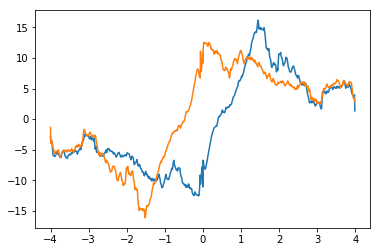

In [33]:
sro32_15_tgm1=read_data_patchwork_averaging(['1658_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_15.0K.txt'],-0.5)

addaweh down

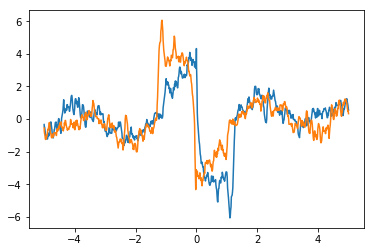

In [34]:
sro32_25_tgm6=read_data_patchwork_averaging(['1158_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_25.1K.txt'],-0.3)

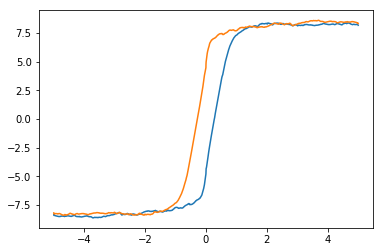

In [1839]:
sro32_25_tgm5=read_data_patchwork_averaging(['1244_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_25.1K.txt'],-0.2)

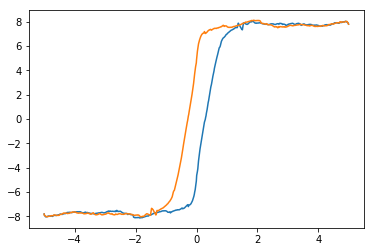

In [1841]:
sro32_25_tgm4=read_data_patchwork_averaging(['1327_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_25.1K.txt','1340_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_25.1K.txt'],-0.1)

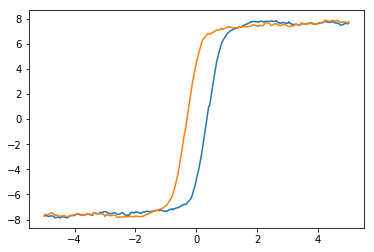

In [1843]:
sro32_25_tgm3=read_data_patchwork_averaging(['1414_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_25.1K.txt'],0)

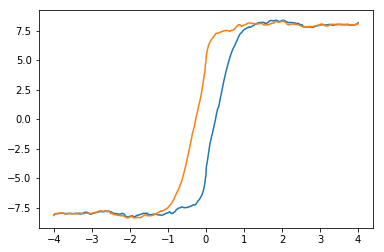

In [1845]:
sro32_25_tgm2=read_data_patchwork_averaging(['1458_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_25.1K.txt'],-0.1)

In [20]:
sro32_25_tgm1=read_data_patchwork_averaging(['1533_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_25.1K.txt'],0)

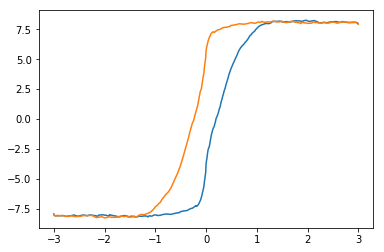

In [1849]:
sro32_25_tg0=read_data_patchwork_averaging(['1608_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_25.1K.txt'],-0.1)

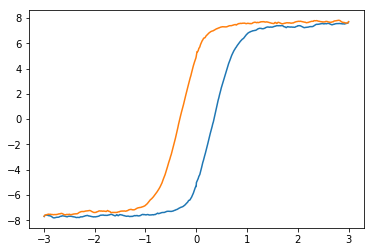

In [1852]:
sro32_25_tg1=read_data_patchwork_averaging(['1635_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_25.1K.txt','1649_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_25.1K.txt'],0.1)

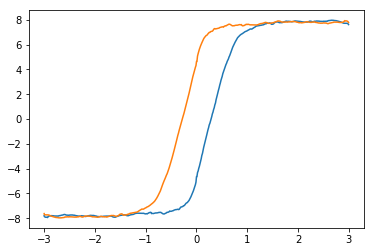

In [1853]:
sro32_25_tg2=read_data_patchwork_averaging(['1710_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_25.1K.txt','1716_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_25.1K.txt'],0)

In [1909]:
sro32_25_tg3=read_data_patchwork_averaging(['1807_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_25.1K.txt','1814_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_25.1K.txt'],0.1)

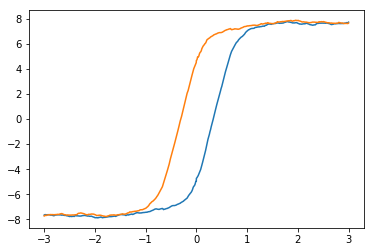

In [1855]:
sro32_25_tg4=read_data_patchwork_averaging(['1834_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_25.1K.txt','1841_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_25.1K.txt'],0)

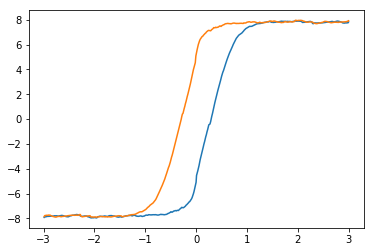

In [1857]:
sro32_25_tg5=read_data_patchwork_averaging(['1901_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG5_5.0V_25.1K.txt'],-0.05)

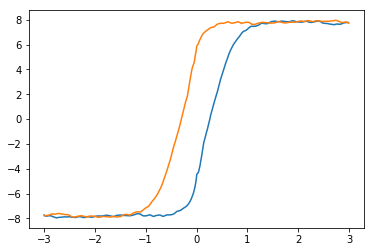

In [1858]:
sro32_25_tg6=read_data_patchwork_averaging(['1926_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_25.1K.txt','1933_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_25.1K.txt'],0)

In [1816]:
def all_together_now_shifted(filelist,slopefit,avgnumber):
    h=[(read_data_patchwork_averaging(filelist[i],slopefit=0.01,avgnumber=avgnumber)) for i in range(len(filelist))]
    fig,ax=plt.subplots(figsize=(30,7))
    for i in range(len(h)):
        ax.plot(h[i][0]+4*i,h[i][1],color='tab:blue')
        ax.plot(-h[i][0]+4*i,-h[i][1],color='tab:red')
    plt.axhline(0,linestyle='--',color='gray')
    plt.savefig('25_loops.eps', format='eps',bbox_inches='tight')
    plt.show()

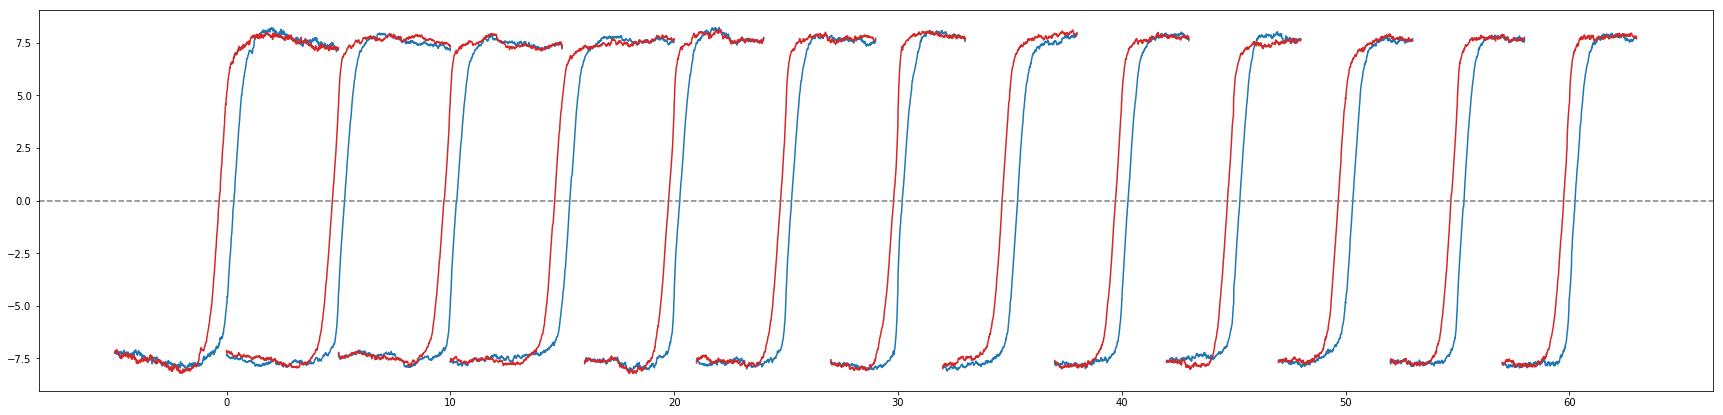

In [1808]:
all_together_now_shifted([['1158_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_25.1K.txt'],
                          ['1244_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_25.1K.txt'],
                          ['1327_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_25.1K.txt','1340_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_25.1K.txt'],
                          ['1414_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_25.1K.txt'],
                          ['1458_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_25.1K.txt'],
                          ['1533_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_25.1K.txt'],
                          ['1608_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_25.1K.txt'],
                          ['1635_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_25.1K.txt','1649_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_25.1K.txt'],
                          ['1710_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_25.1K.txt','1716_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_25.1K.txt'],
                          ['1807_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_25.1K.txt','1814_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_25.1K.txt'],
                          ['1834_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_25.1K.txt','1841_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_25.1K.txt'],
                          ['1901_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG5_5.0V_25.1K.txt'],
                          ['1926_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_25.1K.txt','1933_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_25.1K.txt']],
                         [0],avgnumber=0)

IndexError: invalid index to scalar variable.

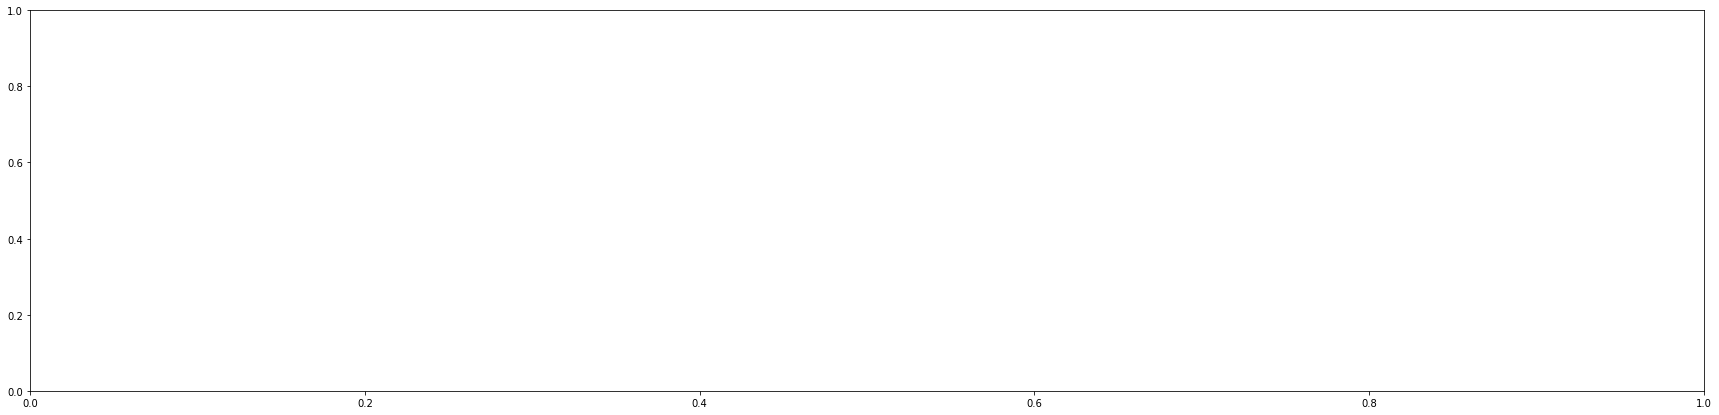

In [1867]:
all_together_now_shifted([#['1608_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_25.1K.txt'],
#                           ['1533_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_25.1K.txt'],
#                           ['1458_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_25.1K.txt'],
#                           ['1414_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_25.1K.txt'],
#                           ['1327_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_25.1K.txt','1340_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_25.1K.txt'],
#                           ['1244_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_25.1K.txt'],
#                           ['1158_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_25.1K.txt'],
                          ['1635_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_25.1K.txt','1649_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_25.1K.txt'],
                          ['1710_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_25.1K.txt','1716_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_25.1K.txt'],
                          ['1807_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_25.1K.txt','1814_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_25.1K.txt'],
                          ['1834_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_25.1K.txt','1841_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_25.1K.txt'],
                          ['1901_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG5_5.0V_25.1K.txt'],
                          ['1926_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_25.1K.txt','1933_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_25.1K.txt'] 
                         ],
                        [0],0)

In [168]:
def coercivity_w_tg(filelist1,filelist2,filelist3,slopefit1,slopefit2,slopefit3):
    data1=[(read_data_patchwork_averaging(filelist1[i],slopefit=slopefit1[i],sign=1,avgnumber=0))[0] for i in range(len(filelist1))]
    data2=[(read_data_patchwork_averaging(filelist2[i],slopefit=slopefit2[i],sign=1,avgnumber=0))[0] for i in range(len(filelist2))]
    
    pos=[(read_data_patchwork_averaging(filelist3[i],slopefit=slopefit3[i],sign=1,avgnumber=0)[0]) for i in range(len(filelist3))]
    print(len(data1),len(data2),len(pos))
    fig,ax=plt.subplots()
    #ax2=ax.twinx()
    #ax3=ax.twinx()
    ax.scatter(np.array([-6,-5,-4,-3,-2,-1,0]),pos,color='tab:blue')
    ax.scatter(np.array([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]),data1,color='tab:red')
    ax.scatter(np.array([-6,-5,-4,-3,-2,-2,-1,0,0,1,2,3,4,5,6]),data2,color='tab:green') 
    ax.plot(np.array([-6,-5,-4,-3,-2,-1,0]),pos,color='tab:blue')
    ax.plot(np.array([-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]),data1,color='tab:red')
    ax.plot(np.array([-6,-5,-4,-3,-2,-2,-1,0,0,1,2,3,4,5,6]),data2,color='tab:green') 
    
    ax.set_ylabel('Coercive field [ T ]')#,color='tab:blue')
    ax.yaxis.label.set_size(18)
    ax.set_xlabel('Top gate [ V ]')
    ax.xaxis.label.set_size(18)
    #ax.tick_params(axis='y', labelcolor='tab:blue')
    #ax2.tick_params(axis='y', labelcolor='tab:red')
    #ax3.tick_params(axis='y', labelcolor='tab:green')
    fig.tight_layout()
    plt.show

In [169]:
coercivity_w_tg([['1158_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_25.1K.txt'],
                  ['1244_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_25.1K.txt'],
                  ['1327_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_25.1K.txt','1340_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_25.1K.txt'],
                  ['1414_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_25.1K.txt'],
                  ['1458_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_25.1K.txt'],
                  ['1533_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_25.1K.txt'],
                  ['1608_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_25.1K.txt'],
                  ['1635_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_25.1K.txt','1649_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_25.1K.txt'],
                  ['1710_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_25.1K.txt','1716_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_25.1K.txt'],
                  ['1807_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_25.1K.txt','1814_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_25.1K.txt'],
                  ['1834_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_25.1K.txt','1841_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_25.1K.txt'],
                  ['1901_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG5_5.0V_25.1K.txt'],
                  ['1926_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_25.1K.txt','1933_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_25.1K.txt']],
                [['1951_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_30.1K.txt'],
                 ['1712_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_30.1K.txt'],
                 ['1918_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_30.1K.txt'],
                 ['1636_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_30.1K.txt'],
                 ['1602_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],
                 ['1844_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],
                 ['1528_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_30.1K.txt'],
                 ['1454_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],
                 ['1755_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt','1812_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],
                 ['1754_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_30.1K.txt'],
                 ['2012_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_30.1K.txt'],
                 ['1827_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_30.1K.txt'],
                 ['2039_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt','2052_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt'],
                 ['1901_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG5_5.0V_30.1K.txt'],
                 ['1051_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt','1100_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt']],
                [['1332_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_15.1K.txt'],
                          ['1405_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_15.0K.txt'],
                          ['1441_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_15.1K.txt'],
                          ['1515_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_15.0K.txt'],
                          ['1625_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_15.1K.txt'],
                          ['1658_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_15.0K.txt'],
                          ['1256_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_15.1K.txt']
                         ],
                        
                 [-0.3,-0.2,-0.1,0.00000000001,-0.1,0.00000000001,-0.1,0.1,0.00000000001,0.00000000001,0.00000000001,-0.05,0.00000000001],
                [-0.03,0.00000000001,0.3,0.2,0.1,0.2,0.05,0.02,0.01,0.15,0.2,0.4,0.01,0.05,0.00000000001],[0.00000000001,-0.2,-0.2,-0.3,-0.1,-0.5,0.00000000001])

IndexError: invalid index to scalar variable.

In [18]:
from scipy.interpolate import make_interp_spline, BSpline

In [75]:
def sro32_plot_loop_height_and_slope(filelist1,filelist2,slopefit1,slopefit2):
    tg1=[-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6]
    tg2=[-6,-5,-4,-3,-2,-2,-1,0,0,1,2,3,4,5,6]
    loops1=slopefit1
    loops2=slopefit2
    heights1=[(read_data_patchwork_averaging(filelist1[i],slopefit=slopefit1[i],sign=1,avgnumber=0))[0][1] for i in range(len(filelist1))]
    heights2=[(read_data_patchwork_averaging(filelist2[i],slopefit=slopefit2[i],sign=1,avgnumber=0))[0][1] for i in range(len(filelist2))]
    rxx1=[0.5*(read_data_patchwork_averaging(filelist1[i],slopefit=slopefit1[i],sign=1,avgnumber=0))[1] for i in range(len(filelist1))]
    rxx2=[0.5*(read_data_patchwork_averaging(filelist2[i],slopefit=slopefit2[i],sign=1,avgnumber=0))[1] for i in range(len(filelist2))]
    
    fig, ax = plt.subplots()
    ax.scatter(tg1,rxx1,color='tab:blue')
    ax2=ax.twinx()
    ax2.scatter(tg2,rxx2,color='tab:red')
    
    
#     ax.plot(tg1,rxx1,color='tab:blue')
#     ax2.plot(tg2,rxx2,color='tab:red')
    ax.set_ylabel('Sheet resistance [ Ohm ]')#,color='tab:blue')
    ax.yaxis.label.set_size(18)
    ax.set_xlabel('Top gate [ V ]')
    ax.xaxis.label.set_size(18)
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    
    ax.xaxis.set_ticks([-8,-4,0,4,8])
    ax.xaxis.set_ticklabels([-8,-4,0,4,8],fontsize=14)
    
    ax.yaxis.set_ticks([3690,3665,3650])
    ax.yaxis.set_ticklabels([3690,3665,3650],fontsize=14)
    
    ax2.yaxis.set_ticks([3430,3410,3390])
    ax2.yaxis.set_ticklabels([3430,3410,3390],fontsize=14)
    plt.show()
    
    fig, ax = plt.subplots()
    ax2=ax.twinx()
    ax.scatter(tg1,heights1,color='tab:blue')
    ax2.scatter(tg2,heights2,color='tab:red')
#     ax.plot(tg1,heights1,color='tab:blue')
#     ax2.plot(tg2,heights2,color='tab:red')
    ax.set_ylabel('Loop height [ Ohm ]')#,color='tab:blue')
    ax.yaxis.label.set_size(18)
    ax.set_xlabel('Top gate [ V ]')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax.xaxis.label.set_size(18)
    plt.show()
    
    fig, ax = plt.subplots()
    ax2=ax.twinx()
    ax.scatter(tg1,slopefit1,color='tab:blue')
    ax2.scatter(tg2,slopefit2,color='tab:red')
    ax.plot(tg1,slopefit1,color='tab:blue')
    ax2.plot(tg2,slopefit2,color='tab:red')
#     ax.plot(tg1,slopefit1,color='tab:blue')
#     ax2.plot(tg2,slopefit2,color='tab:red')
    ax.set_ylabel('OHE slope [ Ohm ]')#,color='tab:blue')
    ax.yaxis.label.set_size(18)
    ax.set_xlabel('Top gate [ V ]')
    ax.tick_params(axis='y', labelcolor='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:red')
    ax.xaxis.label.set_size(18)
    plt.show()

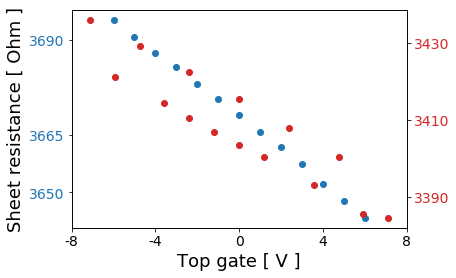

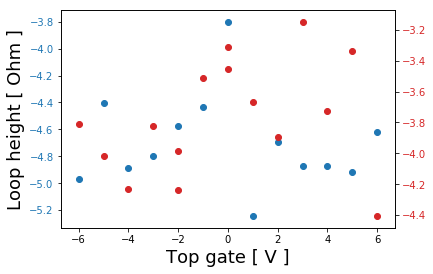

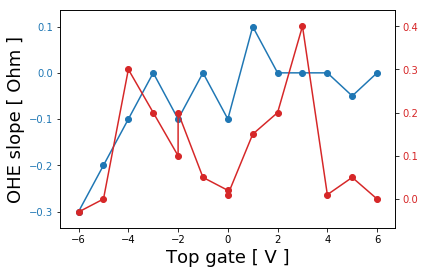

In [76]:
sro32_plot_loop_height_and_slope([['1158_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_25.1K.txt'],
                  ['1244_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_25.1K.txt'],
                  ['1327_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_25.1K.txt','1340_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_25.1K.txt'],
                  ['1414_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_25.1K.txt'],
                  ['1458_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_25.1K.txt'],
                  ['1533_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_25.1K.txt'],
                  ['1608_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_25.1K.txt'],
                  ['1635_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_25.1K.txt','1649_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_25.1K.txt'],
                  ['1710_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_25.1K.txt','1716_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_25.1K.txt'],
                  ['1807_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_25.1K.txt','1814_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_25.1K.txt'],
                  ['1834_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_25.1K.txt','1841_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_25.1K.txt'],
                  ['1901_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG5_5.0V_25.1K.txt'],
                  ['1926_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_25.1K.txt','1933_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_25.1K.txt']],
                [['1951_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_30.1K.txt'],
                 ['1712_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-5_-5.0V_30.1K.txt'],
                 ['1918_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-4_-4.0V_30.1K.txt'],
                 ['1636_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-3_-3.0V_30.1K.txt'],
                 ['1602_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],
                 ['1844_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-2_-2.0V_30.1K.txt'],
                 ['1528_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-1_-1.0V_30.1K.txt'],
                 ['1454_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],
                 ['1755_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt','1812_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_30.1K.txt'],
                 ['1754_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG1_1.0V_30.1K.txt'],
                 ['2012_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG2_2.0V_30.1K.txt'],
                 ['1827_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG3_3.0V_30.1K.txt'],
                 ['2039_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt','2052_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG4_4.0V_30.1K.txt'],
                 ['1901_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG5_5.0V_30.1K.txt'],
                 ['1051_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt','1100_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_30.0K.txt'],
                ],
                
               [-0.3,-0.2,-0.1,0,-0.1,0,-0.1,0.1,0,0,0,-0.05,0],[-0.03,0,0.3,0.2,0.1,0.2,0.05,0.02,0.01,0.15,0.2,0.4,0.01,0.05,0])

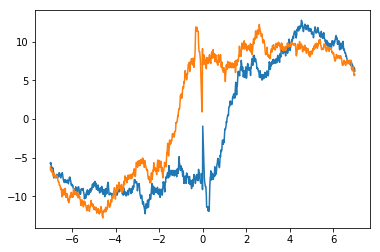

In [2104]:
a=read_data_patchwork_averaging(['1414_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_5.9K.txt','1429_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_5.9K.txt'],0)

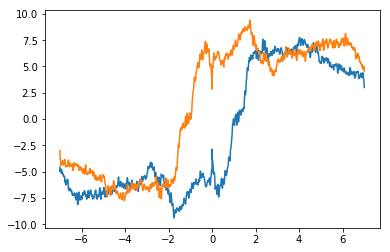

In [2102]:
a=read_data_patchwork_averaging(['1524_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_7.4K.txt','1538_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_7.4K.txt'],0.4)

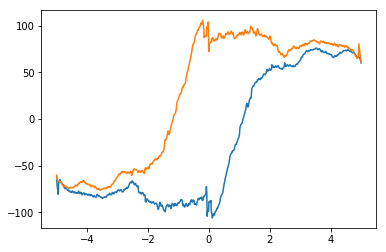

In [2100]:
a=read_data_patchwork_averaging(['1625_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_7.5K.txt','1635_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_7.4K.txt'],-0.2,10,8)

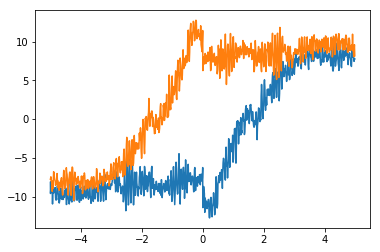

In [2108]:
a=read_data_patchwork_averaging(['1710_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_7.5K.txt','1722_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_7.4K.txt'],0,0)

In [2127]:
def all_together_now_shifted(filelist,slopefit,signs,avgnumber):
    h=[(read_data_patchwork_averaging(filelist[i],slopefit=slopefit[i],sign=signs[i],avgnumber=avgnumber)) for i in range(len(filelist))]
    fig,ax=plt.subplots(figsize=(30,7))
    for i in range(len(h)):
        ax.plot(h[i][0]+9*i,h[i][1],color='tab:blue')
        ax.plot(-h[i][0]+9*i,-h[i][1],color='tab:red')
    plt.axhline(0,linestyle='--',color='gray')
    plt.savefig('7p5_loops.eps', format='eps',bbox_inches='tight')
    plt.show()

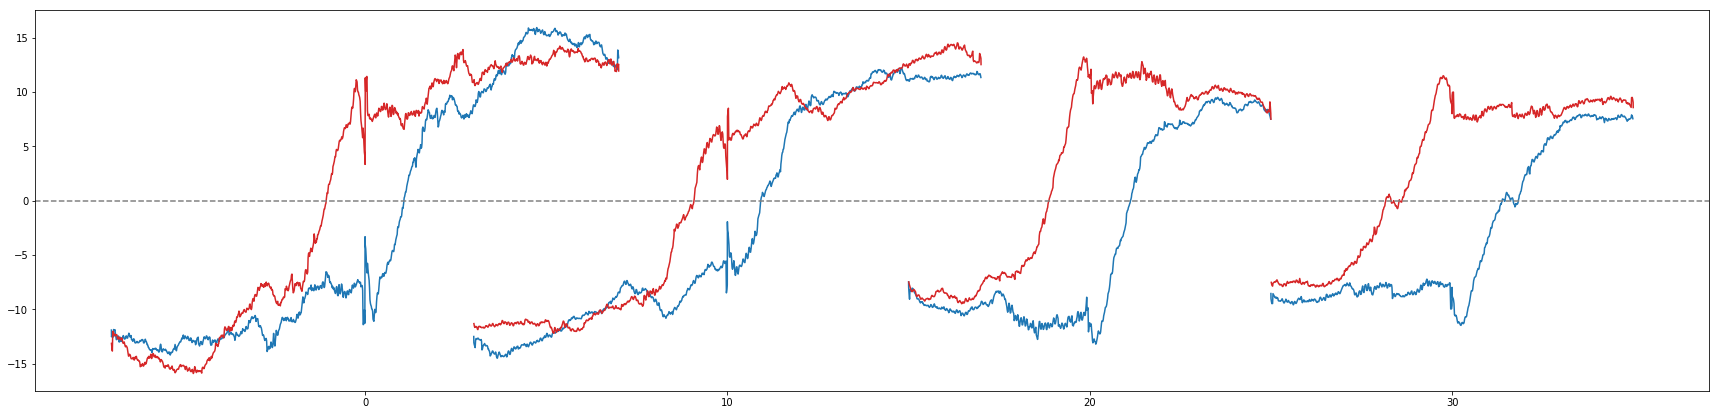

In [2123]:
all_together_now_shifted([['1414_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_5.9K.txt','1429_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_5.9K.txt'],
                          ['1524_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_7.4K.txt','1538_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_7.4K.txt'],
                          ['1625_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_7.5K.txt','1635_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_7.4K.txt'],
                          ['1710_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_7.5K.txt','1722_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_7.4K.txt']
                         ],
                        [-0.8,-0.7,0,0.1],[1,1,1,1],8)

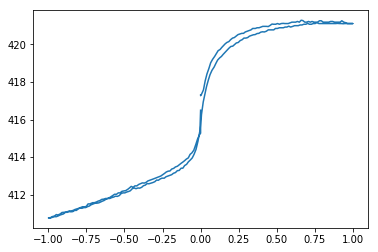

[2, 165, 166, 330]
1.58122596717
loop height: -2.74610197338e-08
[] (array([], dtype=int64),)


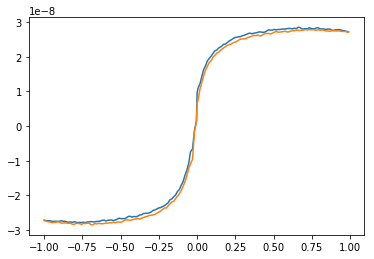

((1.5812259671691986, array([  9.58473038e-09])),)

In [676]:
read_data_patchwork_averaging(['1834_SR032_MR_Hall_I6-3_V5-4_VHall7-5_0.0V_59.8K.txt'],40,0)

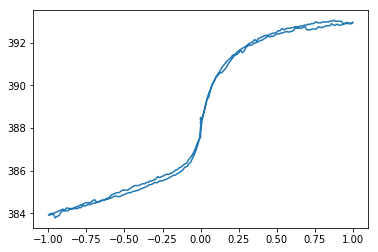

[8, 172, 173, 338]
1.40877003442
loop height: -2.47520825446e-08
[] (array([], dtype=int64),)


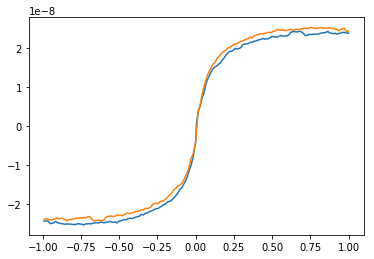

((1.4087700344190199, array([ -4.05569641e-09])),)

In [677]:
read_data_patchwork_averaging(['1907_SR032_MR_Hall_I6-3_V5-4_VHall7-5_0.0V_65.0K.txt'],40,0)

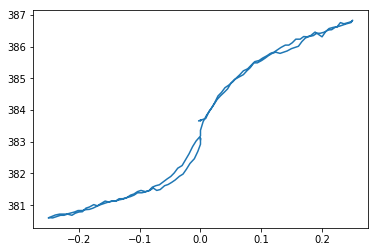

[7, 91, 92, 175]
5.87849955667
loop height: -1.26467648386e-08
[] (array([], dtype=int64),)


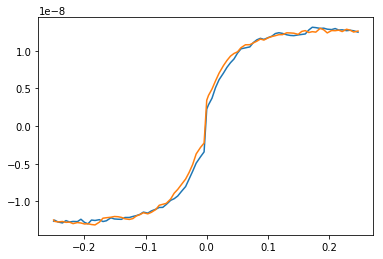

((5.8784995566698868, array([  2.25274657e-09])),)

In [682]:
read_data_patchwork_averaging(['1918_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_65.1K.txt'],10,0)

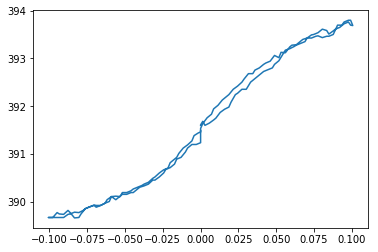

[2, 87, 88, 170]
7.88916949687
loop height: -9.56611746251e-09
[] (array([], dtype=int64),)


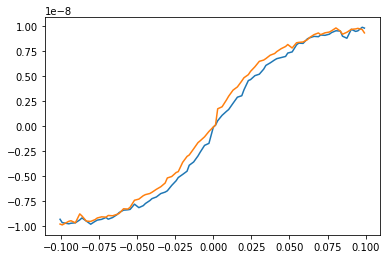

((7.8891694968729462, array([ -1.08381444e-10])),)

In [683]:
read_data_patchwork_averaging(['1926_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_65.2K.txt'],10,0)

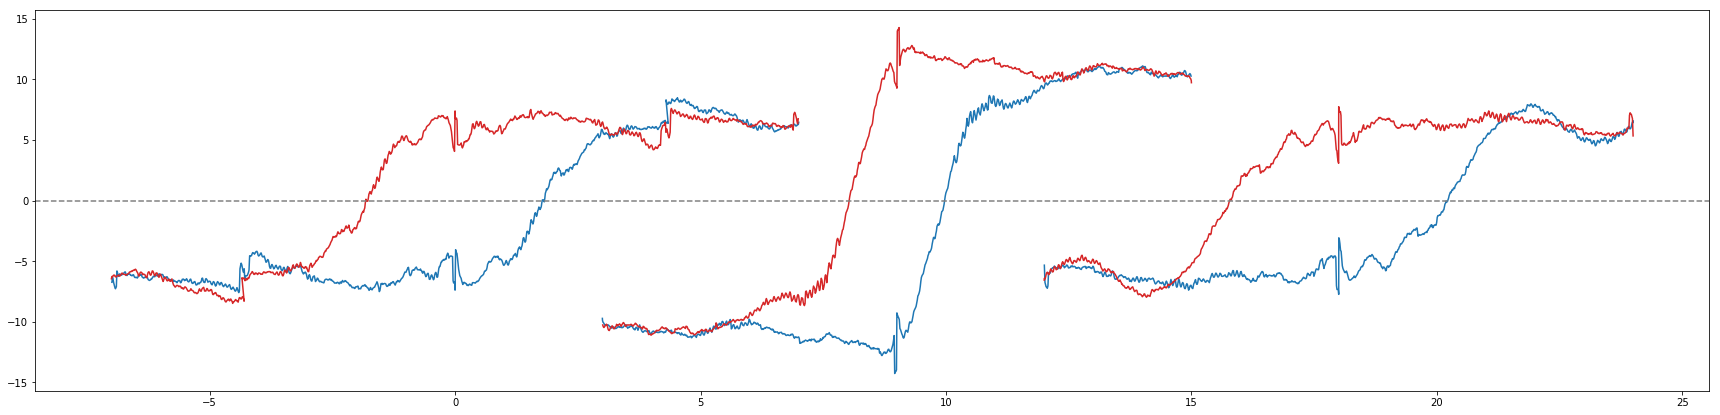

In [2136]:
all_together_now_shifted([['1321_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_7.4K.txt','1335_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_7.4K.txt','1341_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_7.4K.txt'],
                          ['1424_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_7.4K.txt'],
                          ['1518_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_7.4K.txt','1532_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_7.4K.txt']
                         ],[0,-0.5,0],[1,1,1],8)

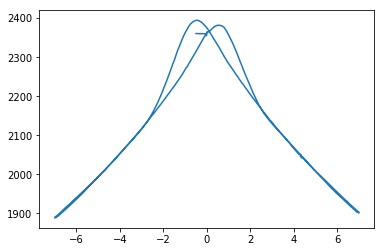

[2, 1137, 1138, 2267]
-0.1
loop height: -1.86983263243e-08
[] (array([], dtype=int64),)


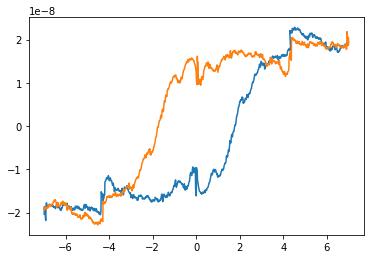

((-0.1, array([ -1.61441274e-08])),)

In [764]:
read_data_patchwork_averaging(['1321_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_7.4K.txt','1335_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_7.4K.txt','1341_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG0_0.0V_7.4K.txt'],-0.1,50,7)

bump at higher field is due to changing the sensitivity during the measurement; the scan was paused but it may not have liked it anyway.

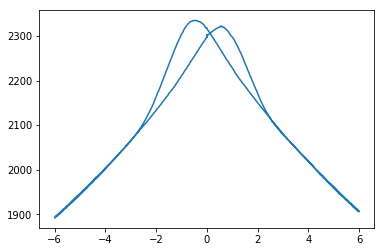

[2, 980, 981, 1958]
-0.1
loop height: -2.25531433632e-08
[ -2.12970967e-08] (array([42]),)


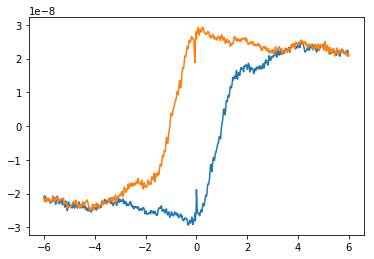

((-0.1, array([ -1.88534568e-08])),)

In [763]:
read_data_patchwork_averaging(['1424_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG6_6.0V_7.4K.txt'],-0.1,100,3)

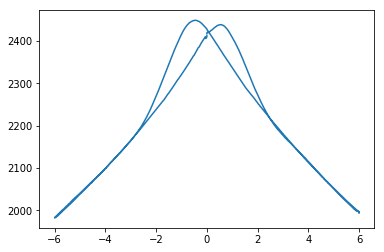

[2, 989, 990, 1970]
-0.3
loop height: -1.88772547111e-08
[] (array([], dtype=int64),)


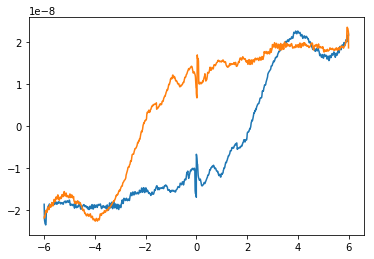

((-0.3, array([ -1.69966854e-08])),)

In [761]:
read_data_patchwork_averaging(['1518_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_7.4K.txt','1532_SR032_MR_Hall_I6-3_V5-4_VHall7-5_TG-6_-6.0V_7.4K.txt'],-0.3,100,8)

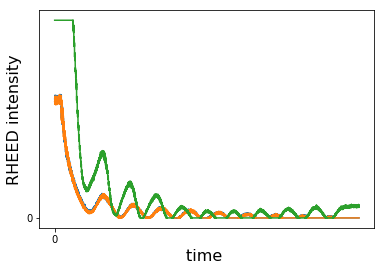

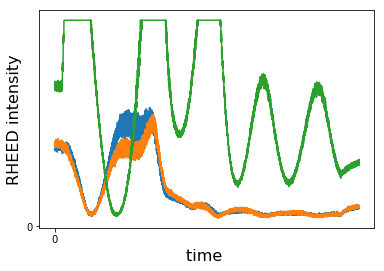

(None, None)

In [15]:
def plot_rheed(filename):
    data=pd.read_csv(filename,sep='\t')
    data.columns = ["signal1", "signal2"]
    fig,ax=plt.subplots()
    #plt.plot(range(len(data.signal1)//3),data.signal1[0:len(data.signal1)//3])
    #plt.plot(range(len(data.signal1)//3),data.signal1[len(data.signal1)//3+1:2*len(data.signal1)//3])
    #plt.plot(range(len(data.signal1)//3),data.signal1[2*len(data.signal1)//3+1:])
    plt.plot(range(len(data.signal2)//3),data.signal2[0:len(data.signal1)//3])
    plt.plot(range(len(data.signal2)//3),data.signal2[len(data.signal1)//3+1:2*len(data.signal1)//3])
    plt.plot(range(len(data.signal2)//3),data.signal2[2*len(data.signal1)//3+1:])
    ax.set_ylabel('RHEED intensity')#,color='tab:blue')
    ax.yaxis.label.set_size(16)
    ax.set_xlabel('time ')
    ax.xaxis.label.set_size(16)
    ax.xaxis.set_ticks([0])
    ax.yaxis.set_ticks([0])
    plt.show()
    
    
plot_rheed('LAO_run.txt'),plot_rheed('SRO_run.txt')